In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,AdamW
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user = nn.Embedding(nb_users, mf_dim)
        self.mf_item = nn.Embedding(nb_items, mf_dim)

        size = mlp_layer_sizes[0] // 2
        self.mlp_user = nn.Embedding(nb_users, size)
        self.mlp_item = nn.Embedding(nb_items, size)

        self.dropout = dropout

        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])\
                                  for i in range(1,nb_mlp_layers)])
        self.last = nn.Linear(mlp_layer_sizes[-1]+mf_dim, 1)     
        

        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)

        #YOUR TASK: Initialze weights ~4 lines of code - use glorot (final MLP has to use lecunn

        self.mf_user.weight.data.normal_(0., 0.01)
        self.mf_item.weight.data.normal_(0., 0.01)
        self.mlp_user.weight.data.normal_(0., 0.01)
        self.mlp_item.weight.data.normal_(0., 0.01)

        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.last)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        mf_user =  self.mf_user(user)
        mf_item =  self.mf_item(item)
        mf = mf_user * mf_item

        mlp_user = self.mlp_user(user)
        mlp_item = self.mlp_item(item)
        mlp = torch.cat((mlp_user, mlp_item), dim=1)
        for i,layer in enumerate(self.mlp):
            mlp = layer(mlp)
            mlp = nn.functional.relu(mlp)
            if self.dropout != 0:
                mlp = nn.functional.dropout(mlp, p=self.dropout, training=self.training)

        x = torch.cat((mf,mlp), dim=1)
        x = self.last(x)
        if sigmoid:
            x = torch.sigmoid(x)

        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self, file_name, negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'], axis=1, inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this! store them in self.users,self.items,self.labels
        #Sample neg users
        user, item = 0, 1
        
        neg_users = ratings[:, user].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:, user], neg_users))
        #sample neg items
        
        neg_items = torch.empty_like(ratings[:,item])
        neg_items = neg_items.repeat(self.negative_samples)
        neg_items = neg_items.random_(0,max_item)
        self.items = torch.cat((ratings[:,item], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,item], dtype=torch.float32)
        neg_label = neg_label.repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,item], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
torch.cuda.is_available()

True

In [6]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
users_num = 944
movies_num = 1683

ds_train = ML100kDataset('ml-100k/u1.base', 2)
ds_test = ML100kDataset('ml-100k/u1.test', 2)

test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

cross_val_num = 3
iter_num = 40

total_length = len(ds_train)
subset_sizes = [total_length // cross_val_num] * cross_val_num
subset_sizes[-1] += total_length % cross_val_num

subset_datasets = random_split(ds_train, subset_sizes)

params = {
    'mf_dim': [8, 24],
    'mlp_layer_sizes': [[128, 64], [128, 64, 32]],
    'learning_rate': [0.01, 0.001],
    'dropout': [0.3, 0.6],
    'weight_decay': [0.0001, 0.00001],
}
tot_iter = 0
max_iter = iter_num * cross_val_num
for val in params.values():
    max_iter *= len(val)

results = pd.DataFrame()

device = torch.device('cpu')

for mf_dim in params['mf_dim']:
    for mlp_layer_sizes in params['mlp_layer_sizes']:
        for learning_rate in params['learning_rate']:
            for dropout in params['dropout']:
                for weight_decay in params['weight_decay']:
                    cv_loss = []
                    for k in range(cross_val_num):
    
                        train_dl = DataLoader(subset_datasets[k], batch_size=16*1024, shuffle=True)
                        
                        model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout).to(device)
                        criterion = nn.BCELoss()
                        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
                        test_loss = []
                        train_loss = []
    
                        for epoch in range(iter_num):
                            model.train()
                            ep_train_loss=[]
                            print(f"Epoch {epoch} Total {tot_iter}/{max_iter}")
                            for (u, i, l) in tqdm.tqdm(train_dl):
                                u, i, l = u.to(device), i.to(device), l.to(device)
                                optimizer.zero_grad()
                                y_hat = model(u, i, sigmoid=True)
                                l = l.unsqueeze(1)
                                loss = criterion(y_hat, l)
                                ep_train_loss.append(loss.detach().cpu().numpy())
                                loss.backward()
                                optimizer.step()
                                
                            train_loss.append(np.mean(ep_train_loss))
                            preds = []
                            ep_test_loss=[]
                            
                            with torch.no_grad():
                                model.eval()
                                for u, i, l in test_dl:
                                    u, i, l = u.to(device), i.to(device), l.to(device)
                                    y_hat = model(u, i, sigmoid=True)
                                    preds.append(y_hat)
                                    l = l.unsqueeze(1)
                                    tl = criterion(y_hat, l)
                                    ep_test_loss.append(tl.detach().cpu().numpy())
                                test_loss.append(np.mean(ep_test_loss))
                            tot_iter += 1
    
                        cv_loss.append(test_loss)
                    cv_loss_mean = np.mean(cv_loss)
    
                    current_run = pd.DataFrame.from_dict({'mf_dim' : [mf_dim],
                                                          'mlp_layer_sizes' : [mlp_layer_sizes], 
                                                          'learning_rate' : [learning_rate],
                                                          'dropout' : [dropout],
                                                          'loss' : [cv_loss_mean],
                                                          'loss_ep' : [{
                                                                        'train' : train_loss,
                                                                        'test'  : test_loss,
                                                                        }]
                                                          })
                    
                    results = pd.concat([results, current_run])

/tmp/ipykernel_12686/2018046521.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)
/tmp/ipykernel_12686/2018046521.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)


Epoch 0 Total 0/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 1 Total 1/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 2 Total 2/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 3 Total 3/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


Epoch 4 Total 4/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 5 Total 5/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 6 Total 6/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 7 Total 7/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 8 Total 8/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 9 Total 9/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 10 Total 10/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 11 Total 11/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 12 Total 12/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 13 Total 13/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 14 Total 14/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 15 Total 15/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 16 Total 16/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 17 Total 17/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 18 Total 18/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 19 Total 19/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 20 Total 20/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 21 Total 21/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 22 Total 22/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 23 Total 23/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 24 Total 24/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 25 Total 25/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 26 Total 26/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 27 Total 27/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 28 Total 28/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 29 Total 29/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 30 Total 30/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 31 Total 31/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 32 Total 32/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 33 Total 33/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 34 Total 34/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 35 Total 35/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 36 Total 36/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 37 Total 37/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 38 Total 38/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 39 Total 39/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 0 Total 40/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 1 Total 41/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 2 Total 42/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 3 Total 43/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 4 Total 44/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 5 Total 45/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 6 Total 46/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 7 Total 47/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 8 Total 48/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 9 Total 49/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 10 Total 50/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 11 Total 51/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 12 Total 52/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 13 Total 53/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 14 Total 54/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 15 Total 55/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 16 Total 56/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 17 Total 57/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 18 Total 58/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 19 Total 59/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 20 Total 60/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 21 Total 61/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 22 Total 62/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 23 Total 63/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 24 Total 64/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 25 Total 65/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 26 Total 66/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 27 Total 67/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 28 Total 68/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 29 Total 69/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 30 Total 70/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 31 Total 71/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 32 Total 72/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 33 Total 73/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 34 Total 74/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 35 Total 75/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 36 Total 76/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 37 Total 77/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 38 Total 78/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 39 Total 79/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 0 Total 80/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 1 Total 81/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 2 Total 82/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 3 Total 83/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 4 Total 84/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 5 Total 85/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 6 Total 86/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 7 Total 87/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 8 Total 88/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 9 Total 89/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 10 Total 90/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 11 Total 91/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 12 Total 92/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 13 Total 93/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 14 Total 94/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 15 Total 95/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 16 Total 96/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 17 Total 97/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 18 Total 98/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 19 Total 99/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 20 Total 100/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 21 Total 101/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 22 Total 102/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 23 Total 103/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 24 Total 104/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 25 Total 105/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 26 Total 106/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


Epoch 27 Total 107/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 28 Total 108/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 29 Total 109/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


Epoch 30 Total 110/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 31 Total 111/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 32 Total 112/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch 33 Total 113/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 34 Total 114/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 35 Total 115/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 36 Total 116/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 37 Total 117/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 38 Total 118/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch 39 Total 119/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 0 Total 120/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 1 Total 121/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 2 Total 122/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 3 Total 123/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 4 Total 124/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 5 Total 125/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 6 Total 126/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 7 Total 127/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 8 Total 128/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 9 Total 129/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 10 Total 130/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 11 Total 131/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 12 Total 132/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 13 Total 133/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 14 Total 134/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


Epoch 15 Total 135/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 16 Total 136/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 17 Total 137/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 18 Total 138/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 19 Total 139/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 20 Total 140/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 21 Total 141/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 22 Total 142/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 23 Total 143/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 24 Total 144/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 25 Total 145/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 26 Total 146/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 27 Total 147/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 28 Total 148/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 29 Total 149/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 30 Total 150/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 31 Total 151/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 32 Total 152/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 33 Total 153/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 34 Total 154/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 35 Total 155/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 36 Total 156/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 37 Total 157/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 38 Total 158/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 39 Total 159/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 0 Total 160/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 1 Total 161/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 2 Total 162/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 3 Total 163/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 4 Total 164/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 5 Total 165/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 6 Total 166/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch 7 Total 167/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 8 Total 168/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 9 Total 169/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


Epoch 10 Total 170/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 11 Total 171/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 12 Total 172/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 13 Total 173/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch 14 Total 174/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 15 Total 175/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 16 Total 176/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 17 Total 177/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 18 Total 178/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 19 Total 179/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s]


Epoch 20 Total 180/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 21 Total 181/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 22 Total 182/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 23 Total 183/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 24 Total 184/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 25 Total 185/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 26 Total 186/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 27 Total 187/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 28 Total 188/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 29 Total 189/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 30 Total 190/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 31 Total 191/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 32 Total 192/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 33 Total 193/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 34 Total 194/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 35 Total 195/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 36 Total 196/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 37 Total 197/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 38 Total 198/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 39 Total 199/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 0 Total 200/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 1 Total 201/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 2 Total 202/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 3 Total 203/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 4 Total 204/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]


Epoch 5 Total 205/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 6 Total 206/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 7 Total 207/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 8 Total 208/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 9 Total 209/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 10 Total 210/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s]


Epoch 11 Total 211/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 12 Total 212/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 13 Total 213/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 14 Total 214/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 15 Total 215/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 16 Total 216/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 17 Total 217/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 18 Total 218/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 19 Total 219/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 20 Total 220/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 21 Total 221/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 22 Total 222/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 23 Total 223/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 24 Total 224/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 25 Total 225/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 26 Total 226/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 27 Total 227/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 28 Total 228/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 29 Total 229/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 30 Total 230/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 31 Total 231/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 32 Total 232/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 33 Total 233/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 34 Total 234/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 35 Total 235/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 36 Total 236/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 37 Total 237/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 38 Total 238/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 39 Total 239/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 0 Total 240/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 1 Total 241/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 2 Total 242/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 3 Total 243/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 4 Total 244/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 5 Total 245/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 6 Total 246/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 7 Total 247/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 8 Total 248/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 9 Total 249/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 10 Total 250/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 11 Total 251/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 12 Total 252/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 13 Total 253/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 14 Total 254/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 15 Total 255/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 16 Total 256/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 17 Total 257/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 18 Total 258/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 19 Total 259/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 20 Total 260/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 21 Total 261/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 22 Total 262/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 23 Total 263/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 24 Total 264/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 25 Total 265/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 26 Total 266/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch 27 Total 267/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 28 Total 268/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 29 Total 269/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 30 Total 270/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s]


Epoch 31 Total 271/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 32 Total 272/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 33 Total 273/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 34 Total 274/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 35 Total 275/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 36 Total 276/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 37 Total 277/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 38 Total 278/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 39 Total 279/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 0 Total 280/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 1 Total 281/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 2 Total 282/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 3 Total 283/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 4 Total 284/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 5 Total 285/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 6 Total 286/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 7 Total 287/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 8 Total 288/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 9 Total 289/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 10 Total 290/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 11 Total 291/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 12 Total 292/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 13 Total 293/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 14 Total 294/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 15 Total 295/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 16 Total 296/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 17 Total 297/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 18 Total 298/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 19 Total 299/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 20 Total 300/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 21 Total 301/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 22 Total 302/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 23 Total 303/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 24 Total 304/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 25 Total 305/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 26 Total 306/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 27 Total 307/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 28 Total 308/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.14it/s]


Epoch 29 Total 309/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 30 Total 310/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 31 Total 311/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch 32 Total 312/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 33 Total 313/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 34 Total 314/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 35 Total 315/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 36 Total 316/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 37 Total 317/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 38 Total 318/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 39 Total 319/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 0 Total 320/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 1 Total 321/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 2 Total 322/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 3 Total 323/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 4 Total 324/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 5 Total 325/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 6 Total 326/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 7 Total 327/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 8 Total 328/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 9 Total 329/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 10 Total 330/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 11 Total 331/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 12 Total 332/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 13 Total 333/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 14 Total 334/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 15 Total 335/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 16 Total 336/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 17 Total 337/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 18 Total 338/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 19 Total 339/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 20 Total 340/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 21 Total 341/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 22 Total 342/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 23 Total 343/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 24 Total 344/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 25 Total 345/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 26 Total 346/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 27 Total 347/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch 28 Total 348/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 29 Total 349/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 30 Total 350/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s]


Epoch 31 Total 351/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


Epoch 32 Total 352/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 33 Total 353/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 34 Total 354/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 35 Total 355/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 36 Total 356/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 37 Total 357/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 38 Total 358/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


Epoch 39 Total 359/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 0 Total 360/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 1 Total 361/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 2 Total 362/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 3 Total 363/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 4 Total 364/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 5 Total 365/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 6 Total 366/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 7 Total 367/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 8 Total 368/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 9 Total 369/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 10 Total 370/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 11 Total 371/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 12 Total 372/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 13 Total 373/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 14 Total 374/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 15 Total 375/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 16 Total 376/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 17 Total 377/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 18 Total 378/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 19 Total 379/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 20 Total 380/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 21 Total 381/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.20it/s]


Epoch 22 Total 382/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 23 Total 383/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 24 Total 384/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 25 Total 385/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 26 Total 386/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 27 Total 387/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 28 Total 388/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 29 Total 389/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 30 Total 390/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 31 Total 391/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 32 Total 392/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 33 Total 393/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 34 Total 394/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 35 Total 395/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 36 Total 396/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 37 Total 397/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 38 Total 398/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 39 Total 399/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 0 Total 400/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 1 Total 401/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 2 Total 402/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 3 Total 403/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 4 Total 404/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


Epoch 5 Total 405/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 6 Total 406/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 7 Total 407/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 8 Total 408/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 9 Total 409/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 10 Total 410/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 11 Total 411/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 12 Total 412/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 13 Total 413/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 14 Total 414/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 15 Total 415/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 16 Total 416/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 17 Total 417/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 18 Total 418/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 19 Total 419/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 20 Total 420/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 21 Total 421/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 22 Total 422/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 23 Total 423/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 24 Total 424/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 25 Total 425/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 26 Total 426/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 27 Total 427/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 28 Total 428/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 29 Total 429/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 30 Total 430/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 31 Total 431/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 32 Total 432/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 33 Total 433/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 34 Total 434/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 35 Total 435/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 36 Total 436/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 37 Total 437/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.14it/s]


Epoch 38 Total 438/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 39 Total 439/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 0 Total 440/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 1 Total 441/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 2 Total 442/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 3 Total 443/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 4 Total 444/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 5 Total 445/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 6 Total 446/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 7 Total 447/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 8 Total 448/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 9 Total 449/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 10 Total 450/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 11 Total 451/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 12 Total 452/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 13 Total 453/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 14 Total 454/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 15 Total 455/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 16 Total 456/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 17 Total 457/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 18 Total 458/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 19 Total 459/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 20 Total 460/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 21 Total 461/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 22 Total 462/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 23 Total 463/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 24 Total 464/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch 25 Total 465/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 26 Total 466/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 27 Total 467/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 28 Total 468/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 29 Total 469/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 30 Total 470/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 31 Total 471/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 32 Total 472/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 33 Total 473/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 34 Total 474/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 35 Total 475/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 36 Total 476/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 37 Total 477/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 38 Total 478/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 39 Total 479/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 0 Total 480/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 1 Total 481/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 2 Total 482/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 3 Total 483/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 4 Total 484/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 5 Total 485/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 6 Total 486/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 7 Total 487/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 8 Total 488/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 9 Total 489/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 10 Total 490/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 11 Total 491/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 12 Total 492/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 13 Total 493/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 14 Total 494/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 15 Total 495/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 16 Total 496/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 17 Total 497/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 18 Total 498/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 19 Total 499/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 20 Total 500/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 21 Total 501/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 22 Total 502/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 23 Total 503/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 24 Total 504/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 25 Total 505/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 26 Total 506/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 27 Total 507/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 28 Total 508/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 29 Total 509/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 30 Total 510/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 31 Total 511/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 32 Total 512/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 33 Total 513/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 34 Total 514/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 35 Total 515/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 36 Total 516/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 37 Total 517/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 38 Total 518/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 39 Total 519/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 0 Total 520/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 1 Total 521/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 2 Total 522/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 3 Total 523/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.18it/s]


Epoch 4 Total 524/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 5 Total 525/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 6 Total 526/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 7 Total 527/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 8 Total 528/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 9 Total 529/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 10 Total 530/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 11 Total 531/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 12 Total 532/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 13 Total 533/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


Epoch 14 Total 534/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 15 Total 535/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 16 Total 536/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 17 Total 537/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 18 Total 538/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s]


Epoch 19 Total 539/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 20 Total 540/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 21 Total 541/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 22 Total 542/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 23 Total 543/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 24 Total 544/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 25 Total 545/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 26 Total 546/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.03it/s]


Epoch 27 Total 547/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


Epoch 28 Total 548/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 29 Total 549/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 30 Total 550/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 31 Total 551/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 32 Total 552/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 33 Total 553/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 34 Total 554/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 35 Total 555/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 36 Total 556/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 37 Total 557/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 38 Total 558/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 39 Total 559/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 0 Total 560/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 1 Total 561/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 2 Total 562/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 3 Total 563/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 4 Total 564/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 5 Total 565/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 6 Total 566/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch 7 Total 567/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 8 Total 568/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 9 Total 569/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 10 Total 570/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 11 Total 571/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 12 Total 572/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 13 Total 573/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 14 Total 574/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 15 Total 575/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 16 Total 576/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 17 Total 577/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 18 Total 578/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 19 Total 579/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 20 Total 580/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


Epoch 21 Total 581/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 22 Total 582/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 23 Total 583/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 24 Total 584/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 25 Total 585/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 26 Total 586/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 27 Total 587/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 28 Total 588/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 29 Total 589/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 30 Total 590/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 31 Total 591/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 32 Total 592/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 33 Total 593/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 34 Total 594/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 35 Total 595/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 36 Total 596/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 37 Total 597/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 38 Total 598/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 39 Total 599/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 0 Total 600/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 1 Total 601/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 2 Total 602/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 3 Total 603/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 4 Total 604/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 5 Total 605/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 6 Total 606/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s]


Epoch 7 Total 607/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 8 Total 608/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch 9 Total 609/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 10 Total 610/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 11 Total 611/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 12 Total 612/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 13 Total 613/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 14 Total 614/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 15 Total 615/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 16 Total 616/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 17 Total 617/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 18 Total 618/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 19 Total 619/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 20 Total 620/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 21 Total 621/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 22 Total 622/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 23 Total 623/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 24 Total 624/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 25 Total 625/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 26 Total 626/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 27 Total 627/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 28 Total 628/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 29 Total 629/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 30 Total 630/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch 31 Total 631/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.09it/s]


Epoch 32 Total 632/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 33 Total 633/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 34 Total 634/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


Epoch 35 Total 635/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 36 Total 636/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 37 Total 637/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 38 Total 638/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s]


Epoch 39 Total 639/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 0 Total 640/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 1 Total 641/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 2 Total 642/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 3 Total 643/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 4 Total 644/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


Epoch 5 Total 645/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 6 Total 646/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 7 Total 647/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


Epoch 8 Total 648/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 9 Total 649/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 10 Total 650/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 11 Total 651/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 12 Total 652/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 13 Total 653/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 14 Total 654/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.25it/s]


Epoch 15 Total 655/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s]


Epoch 16 Total 656/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 17 Total 657/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.16it/s]


Epoch 18 Total 658/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 19 Total 659/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 20 Total 660/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 21 Total 661/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 22 Total 662/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 23 Total 663/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 24 Total 664/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.13it/s]


Epoch 25 Total 665/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 26 Total 666/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 27 Total 667/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 28 Total 668/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 29 Total 669/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 30 Total 670/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 31 Total 671/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 32 Total 672/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 33 Total 673/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 34 Total 674/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 35 Total 675/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


Epoch 36 Total 676/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 37 Total 677/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 38 Total 678/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 39 Total 679/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 0 Total 680/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 1 Total 681/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 2 Total 682/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 3 Total 683/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 4 Total 684/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 5 Total 685/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 6 Total 686/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 7 Total 687/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 8 Total 688/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 9 Total 689/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 10 Total 690/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 11 Total 691/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 12 Total 692/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 13 Total 693/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 14 Total 694/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 15 Total 695/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 16 Total 696/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 17 Total 697/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 18 Total 698/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 19 Total 699/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 20 Total 700/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 21 Total 701/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 22 Total 702/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 23 Total 703/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 24 Total 704/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.23it/s]


Epoch 25 Total 705/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 26 Total 706/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 27 Total 707/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.75it/s]


Epoch 28 Total 708/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 29 Total 709/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 30 Total 710/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch 31 Total 711/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 32 Total 712/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 33 Total 713/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 34 Total 714/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 35 Total 715/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 36 Total 716/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 37 Total 717/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch 38 Total 718/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 39 Total 719/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 0 Total 720/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 1 Total 721/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s]


Epoch 2 Total 722/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 3 Total 723/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 4 Total 724/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 5 Total 725/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 6 Total 726/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 7 Total 727/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 8 Total 728/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 9 Total 729/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 10 Total 730/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 11 Total 731/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 12 Total 732/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 13 Total 733/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 14 Total 734/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 15 Total 735/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 16 Total 736/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 17 Total 737/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 18 Total 738/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 19 Total 739/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 20 Total 740/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 21 Total 741/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 22 Total 742/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


Epoch 23 Total 743/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 24 Total 744/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 25 Total 745/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 26 Total 746/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 27 Total 747/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 28 Total 748/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 29 Total 749/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 30 Total 750/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 31 Total 751/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 32 Total 752/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 33 Total 753/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


Epoch 34 Total 754/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 35 Total 755/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 36 Total 756/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 37 Total 757/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 38 Total 758/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 39 Total 759/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 0 Total 760/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s]


Epoch 1 Total 761/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 2 Total 762/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 3 Total 763/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.34it/s]


Epoch 4 Total 764/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 5 Total 765/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 6 Total 766/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch 7 Total 767/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 8 Total 768/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 9 Total 769/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 10 Total 770/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.39it/s]


Epoch 11 Total 771/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 12 Total 772/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 13 Total 773/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


Epoch 14 Total 774/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 15 Total 775/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 16 Total 776/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch 17 Total 777/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 18 Total 778/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 19 Total 779/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


Epoch 20 Total 780/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 21 Total 781/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 22 Total 782/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 23 Total 783/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 24 Total 784/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 25 Total 785/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 26 Total 786/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 27 Total 787/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 28 Total 788/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s]


Epoch 29 Total 789/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 30 Total 790/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 31 Total 791/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 32 Total 792/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch 33 Total 793/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 34 Total 794/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 35 Total 795/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s]


Epoch 36 Total 796/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 37 Total 797/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 38 Total 798/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.22it/s]


Epoch 39 Total 799/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 0 Total 800/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 1 Total 801/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


Epoch 2 Total 802/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 3 Total 803/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 4 Total 804/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


Epoch 5 Total 805/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 6 Total 806/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 7 Total 807/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 8 Total 808/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 9 Total 809/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 10 Total 810/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 11 Total 811/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 12 Total 812/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 13 Total 813/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 14 Total 814/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 15 Total 815/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 16 Total 816/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.15it/s]


Epoch 17 Total 817/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 18 Total 818/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 19 Total 819/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 20 Total 820/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 21 Total 821/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 22 Total 822/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s]


Epoch 23 Total 823/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 24 Total 824/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 25 Total 825/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 26 Total 826/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 27 Total 827/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 28 Total 828/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 29 Total 829/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


Epoch 30 Total 830/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 31 Total 831/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 32 Total 832/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 33 Total 833/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 34 Total 834/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 35 Total 835/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 36 Total 836/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.18it/s]


Epoch 37 Total 837/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 38 Total 838/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 39 Total 839/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


Epoch 0 Total 840/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 1 Total 841/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 2 Total 842/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.48it/s]


Epoch 3 Total 843/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 4 Total 844/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 5 Total 845/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 6 Total 846/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 7 Total 847/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 8 Total 848/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 9 Total 849/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch 10 Total 850/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 11 Total 851/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 12 Total 852/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 13 Total 853/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 14 Total 854/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 15 Total 855/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 16 Total 856/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 17 Total 857/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 18 Total 858/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 19 Total 859/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 20 Total 860/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 21 Total 861/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 22 Total 862/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 23 Total 863/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 24 Total 864/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 25 Total 865/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 26 Total 866/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 27 Total 867/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch 28 Total 868/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05it/s]


Epoch 29 Total 869/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch 30 Total 870/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.06it/s]


Epoch 31 Total 871/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.27it/s]


Epoch 32 Total 872/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 33 Total 873/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 34 Total 874/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 35 Total 875/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 36 Total 876/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 37 Total 877/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 38 Total 878/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 39 Total 879/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 0 Total 880/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 1 Total 881/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 2 Total 882/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 3 Total 883/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 4 Total 884/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 5 Total 885/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 6 Total 886/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch 7 Total 887/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 8 Total 888/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 9 Total 889/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


Epoch 10 Total 890/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 11 Total 891/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 12 Total 892/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 13 Total 893/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 14 Total 894/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 15 Total 895/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 16 Total 896/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 17 Total 897/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 18 Total 898/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 19 Total 899/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 20 Total 900/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 21 Total 901/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 22 Total 902/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 23 Total 903/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 24 Total 904/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 25 Total 905/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 26 Total 906/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 27 Total 907/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 28 Total 908/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 29 Total 909/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 30 Total 910/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 31 Total 911/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 32 Total 912/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 33 Total 913/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 34 Total 914/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.03it/s]


Epoch 35 Total 915/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 36 Total 916/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 37 Total 917/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 38 Total 918/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 39 Total 919/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 0 Total 920/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 1 Total 921/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 2 Total 922/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 3 Total 923/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 4 Total 924/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 5 Total 925/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 6 Total 926/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 7 Total 927/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 8 Total 928/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 9 Total 929/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 10 Total 930/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 11 Total 931/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 12 Total 932/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 13 Total 933/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 14 Total 934/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 15 Total 935/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 16 Total 936/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 17 Total 937/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 18 Total 938/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 19 Total 939/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 20 Total 940/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 21 Total 941/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 22 Total 942/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 23 Total 943/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 24 Total 944/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 25 Total 945/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 26 Total 946/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 27 Total 947/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 28 Total 948/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 29 Total 949/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 30 Total 950/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 31 Total 951/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 32 Total 952/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 33 Total 953/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 34 Total 954/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 35 Total 955/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 36 Total 956/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 37 Total 957/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 38 Total 958/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 39 Total 959/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 0 Total 960/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 1 Total 961/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 2 Total 962/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 3 Total 963/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 4 Total 964/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 5 Total 965/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 6 Total 966/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 7 Total 967/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 8 Total 968/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


Epoch 9 Total 969/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 10 Total 970/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 11 Total 971/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 12 Total 972/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 13 Total 973/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 14 Total 974/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 15 Total 975/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 16 Total 976/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 17 Total 977/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 18 Total 978/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 19 Total 979/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 20 Total 980/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 21 Total 981/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 22 Total 982/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 23 Total 983/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 24 Total 984/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 25 Total 985/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 26 Total 986/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 27 Total 987/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 28 Total 988/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 29 Total 989/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 30 Total 990/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 31 Total 991/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 32 Total 992/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 33 Total 993/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 34 Total 994/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 35 Total 995/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 36 Total 996/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 37 Total 997/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 38 Total 998/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 39 Total 999/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 0 Total 1000/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 1 Total 1001/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 2 Total 1002/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 3 Total 1003/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 4 Total 1004/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 5 Total 1005/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 6 Total 1006/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 7 Total 1007/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 8 Total 1008/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 9 Total 1009/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 10 Total 1010/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 11 Total 1011/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 12 Total 1012/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 13 Total 1013/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 14 Total 1014/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 15 Total 1015/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 16 Total 1016/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 17 Total 1017/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 18 Total 1018/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 19 Total 1019/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 20 Total 1020/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 21 Total 1021/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 22 Total 1022/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 23 Total 1023/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch 24 Total 1024/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 25 Total 1025/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 26 Total 1026/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.58it/s]


Epoch 27 Total 1027/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 28 Total 1028/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 29 Total 1029/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


Epoch 30 Total 1030/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 31 Total 1031/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 32 Total 1032/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 33 Total 1033/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch 34 Total 1034/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 35 Total 1035/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 36 Total 1036/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch 37 Total 1037/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 38 Total 1038/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 39 Total 1039/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch 0 Total 1040/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 1 Total 1041/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 2 Total 1042/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 3 Total 1043/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 4 Total 1044/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 5 Total 1045/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 6 Total 1046/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 7 Total 1047/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 8 Total 1048/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 9 Total 1049/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 10 Total 1050/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 11 Total 1051/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 12 Total 1052/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 13 Total 1053/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 14 Total 1054/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 15 Total 1055/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 16 Total 1056/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 17 Total 1057/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 18 Total 1058/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 19 Total 1059/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 20 Total 1060/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 21 Total 1061/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 22 Total 1062/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 23 Total 1063/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 24 Total 1064/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 25 Total 1065/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 26 Total 1066/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 27 Total 1067/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 28 Total 1068/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 29 Total 1069/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 30 Total 1070/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 31 Total 1071/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 32 Total 1072/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 33 Total 1073/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 34 Total 1074/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 35 Total 1075/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 36 Total 1076/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 37 Total 1077/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 38 Total 1078/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 39 Total 1079/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 0 Total 1080/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 1 Total 1081/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 2 Total 1082/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 3 Total 1083/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 4 Total 1084/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 5 Total 1085/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 6 Total 1086/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 7 Total 1087/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch 8 Total 1088/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 9 Total 1089/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 10 Total 1090/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 11 Total 1091/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 12 Total 1092/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 13 Total 1093/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 14 Total 1094/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 15 Total 1095/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 16 Total 1096/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 17 Total 1097/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.66it/s]


Epoch 18 Total 1098/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 19 Total 1099/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 20 Total 1100/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.83it/s]


Epoch 21 Total 1101/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 22 Total 1102/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 23 Total 1103/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 24 Total 1104/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 25 Total 1105/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 26 Total 1106/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 27 Total 1107/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 28 Total 1108/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 29 Total 1109/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 30 Total 1110/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 31 Total 1111/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 32 Total 1112/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 33 Total 1113/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.58it/s]


Epoch 34 Total 1114/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 35 Total 1115/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 36 Total 1116/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 37 Total 1117/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 38 Total 1118/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


Epoch 39 Total 1119/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 0 Total 1120/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 1 Total 1121/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 2 Total 1122/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 3 Total 1123/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 4 Total 1124/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 5 Total 1125/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 6 Total 1126/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 7 Total 1127/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 8 Total 1128/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 9 Total 1129/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 10 Total 1130/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 11 Total 1131/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 12 Total 1132/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 13 Total 1133/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 14 Total 1134/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 15 Total 1135/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 16 Total 1136/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 17 Total 1137/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 18 Total 1138/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 19 Total 1139/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 20 Total 1140/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 21 Total 1141/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 22 Total 1142/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 23 Total 1143/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 24 Total 1144/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 25 Total 1145/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 26 Total 1146/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 27 Total 1147/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 28 Total 1148/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 29 Total 1149/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 30 Total 1150/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch 31 Total 1151/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 32 Total 1152/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 33 Total 1153/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


Epoch 34 Total 1154/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 35 Total 1155/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 36 Total 1156/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 37 Total 1157/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 38 Total 1158/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 39 Total 1159/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 0 Total 1160/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 1 Total 1161/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 2 Total 1162/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 3 Total 1163/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch 4 Total 1164/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 5 Total 1165/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 6 Total 1166/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 7 Total 1167/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


Epoch 8 Total 1168/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.96it/s]


Epoch 9 Total 1169/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 10 Total 1170/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 11 Total 1171/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch 12 Total 1172/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Epoch 13 Total 1173/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 14 Total 1174/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 15 Total 1175/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 16 Total 1176/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 17 Total 1177/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.97it/s]


Epoch 18 Total 1178/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 19 Total 1179/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 20 Total 1180/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 21 Total 1181/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 22 Total 1182/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 23 Total 1183/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


Epoch 24 Total 1184/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 25 Total 1185/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 26 Total 1186/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 27 Total 1187/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 28 Total 1188/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch 29 Total 1189/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 30 Total 1190/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 31 Total 1191/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 32 Total 1192/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 33 Total 1193/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 34 Total 1194/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 35 Total 1195/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 36 Total 1196/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 37 Total 1197/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


Epoch 38 Total 1198/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 39 Total 1199/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


Epoch 0 Total 1200/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 1 Total 1201/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch 2 Total 1202/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 3 Total 1203/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 4 Total 1204/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.15it/s]


Epoch 5 Total 1205/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 6 Total 1206/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 7 Total 1207/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 8 Total 1208/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 9 Total 1209/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 10 Total 1210/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 11 Total 1211/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 12 Total 1212/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 13 Total 1213/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 14 Total 1214/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 15 Total 1215/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 16 Total 1216/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 17 Total 1217/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 18 Total 1218/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 19 Total 1219/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 20 Total 1220/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 21 Total 1221/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 22 Total 1222/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 23 Total 1223/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 24 Total 1224/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 25 Total 1225/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 26 Total 1226/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 27 Total 1227/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 28 Total 1228/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 29 Total 1229/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 30 Total 1230/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 31 Total 1231/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 32 Total 1232/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 33 Total 1233/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 34 Total 1234/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch 35 Total 1235/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


Epoch 36 Total 1236/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch 37 Total 1237/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 38 Total 1238/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 39 Total 1239/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 0 Total 1240/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 1 Total 1241/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 2 Total 1242/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 3 Total 1243/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 4 Total 1244/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 5 Total 1245/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 6 Total 1246/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 7 Total 1247/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 8 Total 1248/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 9 Total 1249/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 10 Total 1250/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 11 Total 1251/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 12 Total 1252/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


Epoch 13 Total 1253/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 14 Total 1254/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 15 Total 1255/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 16 Total 1256/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 17 Total 1257/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 18 Total 1258/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 19 Total 1259/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.08it/s]


Epoch 20 Total 1260/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 21 Total 1261/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 22 Total 1262/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 23 Total 1263/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


Epoch 24 Total 1264/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 25 Total 1265/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 26 Total 1266/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 27 Total 1267/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 28 Total 1268/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


Epoch 29 Total 1269/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 30 Total 1270/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 31 Total 1271/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.29it/s]


Epoch 32 Total 1272/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 33 Total 1273/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 34 Total 1274/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 35 Total 1275/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 36 Total 1276/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 37 Total 1277/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.11it/s]


Epoch 38 Total 1278/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.82it/s]


Epoch 39 Total 1279/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 0 Total 1280/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 1 Total 1281/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 2 Total 1282/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 3 Total 1283/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 4 Total 1284/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 5 Total 1285/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 6 Total 1286/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 7 Total 1287/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 8 Total 1288/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 9 Total 1289/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 10 Total 1290/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 11 Total 1291/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 12 Total 1292/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 13 Total 1293/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 14 Total 1294/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 15 Total 1295/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 16 Total 1296/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 17 Total 1297/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 18 Total 1298/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 19 Total 1299/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 20 Total 1300/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 21 Total 1301/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 22 Total 1302/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 23 Total 1303/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 24 Total 1304/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 25 Total 1305/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 26 Total 1306/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 27 Total 1307/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 28 Total 1308/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 29 Total 1309/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 30 Total 1310/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 31 Total 1311/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


Epoch 32 Total 1312/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 33 Total 1313/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 34 Total 1314/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 35 Total 1315/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 36 Total 1316/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


Epoch 37 Total 1317/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 38 Total 1318/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 39 Total 1319/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.97it/s]


Epoch 0 Total 1320/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 1 Total 1321/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 2 Total 1322/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 3 Total 1323/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 4 Total 1324/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 5 Total 1325/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 6 Total 1326/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 7 Total 1327/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 8 Total 1328/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 9 Total 1329/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 10 Total 1330/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 11 Total 1331/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 12 Total 1332/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 13 Total 1333/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 14 Total 1334/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s]


Epoch 15 Total 1335/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 16 Total 1336/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 17 Total 1337/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 18 Total 1338/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 19 Total 1339/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 20 Total 1340/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 21 Total 1341/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 22 Total 1342/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 23 Total 1343/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 24 Total 1344/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 25 Total 1345/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 26 Total 1346/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 27 Total 1347/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 28 Total 1348/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 29 Total 1349/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 30 Total 1350/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 31 Total 1351/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


Epoch 32 Total 1352/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 33 Total 1353/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 34 Total 1354/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 35 Total 1355/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 36 Total 1356/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 37 Total 1357/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 38 Total 1358/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 39 Total 1359/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 0 Total 1360/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s]


Epoch 1 Total 1361/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 2 Total 1362/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 3 Total 1363/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.52it/s]


Epoch 4 Total 1364/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 5 Total 1365/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 6 Total 1366/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 7 Total 1367/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s]


Epoch 8 Total 1368/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 9 Total 1369/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 10 Total 1370/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 11 Total 1371/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 12 Total 1372/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 13 Total 1373/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 14 Total 1374/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 15 Total 1375/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 16 Total 1376/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 17 Total 1377/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 18 Total 1378/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 19 Total 1379/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 20 Total 1380/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 21 Total 1381/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 22 Total 1382/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 23 Total 1383/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 24 Total 1384/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 25 Total 1385/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 26 Total 1386/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 27 Total 1387/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 28 Total 1388/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 29 Total 1389/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 30 Total 1390/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 31 Total 1391/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


Epoch 32 Total 1392/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


Epoch 33 Total 1393/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 34 Total 1394/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 35 Total 1395/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 36 Total 1396/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 37 Total 1397/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


Epoch 38 Total 1398/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


Epoch 39 Total 1399/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.47it/s]


Epoch 0 Total 1400/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 1 Total 1401/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch 2 Total 1402/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 3 Total 1403/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 4 Total 1404/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 5 Total 1405/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 6 Total 1406/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 7 Total 1407/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 8 Total 1408/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 9 Total 1409/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 10 Total 1410/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 11 Total 1411/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 12 Total 1412/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 13 Total 1413/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 14 Total 1414/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


Epoch 15 Total 1415/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 16 Total 1416/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 17 Total 1417/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 18 Total 1418/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 19 Total 1419/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 20 Total 1420/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 21 Total 1421/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 22 Total 1422/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 23 Total 1423/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 24 Total 1424/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 25 Total 1425/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 26 Total 1426/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 27 Total 1427/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 28 Total 1428/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.20it/s]


Epoch 29 Total 1429/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 30 Total 1430/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 31 Total 1431/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 32 Total 1432/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 33 Total 1433/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


Epoch 34 Total 1434/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 35 Total 1435/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 36 Total 1436/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 37 Total 1437/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 38 Total 1438/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch 39 Total 1439/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 0 Total 1440/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 1 Total 1441/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 2 Total 1442/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 3 Total 1443/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 4 Total 1444/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 5 Total 1445/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 6 Total 1446/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 7 Total 1447/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 8 Total 1448/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 9 Total 1449/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 10 Total 1450/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 11 Total 1451/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch 12 Total 1452/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 13 Total 1453/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 14 Total 1454/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch 15 Total 1455/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 16 Total 1456/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 17 Total 1457/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch 18 Total 1458/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 19 Total 1459/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 20 Total 1460/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.09it/s]


Epoch 21 Total 1461/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 22 Total 1462/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 23 Total 1463/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 24 Total 1464/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 25 Total 1465/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 26 Total 1466/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 27 Total 1467/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 28 Total 1468/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 29 Total 1469/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 30 Total 1470/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 31 Total 1471/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


Epoch 32 Total 1472/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 33 Total 1473/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 34 Total 1474/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 35 Total 1475/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 36 Total 1476/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 37 Total 1477/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 38 Total 1478/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 39 Total 1479/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch 0 Total 1480/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 1 Total 1481/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 2 Total 1482/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 3 Total 1483/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 4 Total 1484/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 5 Total 1485/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 6 Total 1486/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 7 Total 1487/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 8 Total 1488/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 9 Total 1489/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 10 Total 1490/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 11 Total 1491/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 12 Total 1492/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 13 Total 1493/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 14 Total 1494/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 15 Total 1495/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 16 Total 1496/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 17 Total 1497/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 18 Total 1498/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 19 Total 1499/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 20 Total 1500/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 21 Total 1501/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 22 Total 1502/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 23 Total 1503/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 24 Total 1504/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 25 Total 1505/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 26 Total 1506/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 27 Total 1507/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 28 Total 1508/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 29 Total 1509/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 30 Total 1510/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 31 Total 1511/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 32 Total 1512/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 33 Total 1513/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 34 Total 1514/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 35 Total 1515/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 36 Total 1516/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 37 Total 1517/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 38 Total 1518/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 39 Total 1519/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 0 Total 1520/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 1 Total 1521/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 2 Total 1522/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 3 Total 1523/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 4 Total 1524/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 5 Total 1525/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 6 Total 1526/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 7 Total 1527/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 8 Total 1528/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 9 Total 1529/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 10 Total 1530/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 11 Total 1531/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 12 Total 1532/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 13 Total 1533/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 14 Total 1534/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 15 Total 1535/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 16 Total 1536/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 17 Total 1537/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 18 Total 1538/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 19 Total 1539/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 20 Total 1540/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 21 Total 1541/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 22 Total 1542/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 23 Total 1543/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.10it/s]


Epoch 24 Total 1544/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 25 Total 1545/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 26 Total 1546/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 27 Total 1547/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 28 Total 1548/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 29 Total 1549/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 30 Total 1550/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 31 Total 1551/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 32 Total 1552/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 33 Total 1553/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 34 Total 1554/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 35 Total 1555/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 36 Total 1556/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 37 Total 1557/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 38 Total 1558/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 39 Total 1559/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 0 Total 1560/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 1 Total 1561/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 2 Total 1562/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 3 Total 1563/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 4 Total 1564/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 5 Total 1565/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 6 Total 1566/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 7 Total 1567/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 8 Total 1568/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 9 Total 1569/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 10 Total 1570/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 11 Total 1571/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 12 Total 1572/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 13 Total 1573/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 14 Total 1574/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 15 Total 1575/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 16 Total 1576/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 17 Total 1577/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 18 Total 1578/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 19 Total 1579/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 20 Total 1580/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 21 Total 1581/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 22 Total 1582/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 23 Total 1583/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 24 Total 1584/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 25 Total 1585/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 26 Total 1586/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 27 Total 1587/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 28 Total 1588/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 29 Total 1589/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 30 Total 1590/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 31 Total 1591/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 32 Total 1592/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 33 Total 1593/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 34 Total 1594/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 35 Total 1595/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 36 Total 1596/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 37 Total 1597/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 38 Total 1598/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 39 Total 1599/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 0 Total 1600/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 1 Total 1601/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 2 Total 1602/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 3 Total 1603/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 4 Total 1604/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 5 Total 1605/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 6 Total 1606/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 7 Total 1607/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 8 Total 1608/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 9 Total 1609/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 10 Total 1610/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 11 Total 1611/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 12 Total 1612/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 13 Total 1613/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 14 Total 1614/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 15 Total 1615/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 16 Total 1616/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 17 Total 1617/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 18 Total 1618/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 19 Total 1619/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 20 Total 1620/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 21 Total 1621/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 22 Total 1622/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 23 Total 1623/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 24 Total 1624/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 25 Total 1625/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 26 Total 1626/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 27 Total 1627/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 28 Total 1628/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 29 Total 1629/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 30 Total 1630/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 31 Total 1631/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 32 Total 1632/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 33 Total 1633/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 34 Total 1634/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 35 Total 1635/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 36 Total 1636/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 37 Total 1637/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 38 Total 1638/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 39 Total 1639/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 0 Total 1640/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 1 Total 1641/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 2 Total 1642/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 3 Total 1643/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 4 Total 1644/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 5 Total 1645/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 6 Total 1646/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 7 Total 1647/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 8 Total 1648/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 9 Total 1649/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 10 Total 1650/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 11 Total 1651/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 12 Total 1652/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 13 Total 1653/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 14 Total 1654/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 15 Total 1655/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 16 Total 1656/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 17 Total 1657/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 18 Total 1658/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 19 Total 1659/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 20 Total 1660/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 21 Total 1661/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 22 Total 1662/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 23 Total 1663/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 24 Total 1664/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 25 Total 1665/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 26 Total 1666/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 27 Total 1667/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 28 Total 1668/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 29 Total 1669/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 30 Total 1670/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 31 Total 1671/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 32 Total 1672/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 33 Total 1673/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 34 Total 1674/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 35 Total 1675/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 36 Total 1676/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 37 Total 1677/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 38 Total 1678/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 39 Total 1679/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 0 Total 1680/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 1 Total 1681/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 2 Total 1682/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 3 Total 1683/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 4 Total 1684/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 5 Total 1685/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 6 Total 1686/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 7 Total 1687/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 8 Total 1688/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 9 Total 1689/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 10 Total 1690/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 11 Total 1691/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 12 Total 1692/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


Epoch 13 Total 1693/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 14 Total 1694/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 15 Total 1695/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 16 Total 1696/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 17 Total 1697/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.09it/s]


Epoch 18 Total 1698/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 19 Total 1699/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 20 Total 1700/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 21 Total 1701/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 22 Total 1702/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 23 Total 1703/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


Epoch 24 Total 1704/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s]


Epoch 25 Total 1705/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 26 Total 1706/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 27 Total 1707/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 28 Total 1708/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 29 Total 1709/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 30 Total 1710/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 31 Total 1711/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.96it/s]


Epoch 32 Total 1712/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 33 Total 1713/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 34 Total 1714/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 35 Total 1715/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 36 Total 1716/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 37 Total 1717/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 38 Total 1718/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 39 Total 1719/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch 0 Total 1720/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 1 Total 1721/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 2 Total 1722/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 3 Total 1723/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 4 Total 1724/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 5 Total 1725/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 6 Total 1726/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 7 Total 1727/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 8 Total 1728/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 9 Total 1729/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 10 Total 1730/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch 11 Total 1731/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 12 Total 1732/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 13 Total 1733/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


Epoch 14 Total 1734/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 15 Total 1735/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 16 Total 1736/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.66it/s]


Epoch 17 Total 1737/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 18 Total 1738/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 19 Total 1739/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 20 Total 1740/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 21 Total 1741/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 22 Total 1742/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.08it/s]


Epoch 23 Total 1743/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 24 Total 1744/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 25 Total 1745/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 26 Total 1746/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.27it/s]


Epoch 27 Total 1747/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 28 Total 1748/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 29 Total 1749/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 30 Total 1750/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 31 Total 1751/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 32 Total 1752/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 33 Total 1753/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 34 Total 1754/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 35 Total 1755/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 36 Total 1756/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 37 Total 1757/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 38 Total 1758/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 39 Total 1759/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 0 Total 1760/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.87it/s]


Epoch 1 Total 1761/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 2 Total 1762/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 3 Total 1763/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 4 Total 1764/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 5 Total 1765/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 6 Total 1766/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 7 Total 1767/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 8 Total 1768/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 9 Total 1769/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 10 Total 1770/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 11 Total 1771/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 12 Total 1772/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s]


Epoch 13 Total 1773/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 14 Total 1774/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 15 Total 1775/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 16 Total 1776/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch 17 Total 1777/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 18 Total 1778/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 19 Total 1779/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 20 Total 1780/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 21 Total 1781/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 22 Total 1782/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 23 Total 1783/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 24 Total 1784/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 25 Total 1785/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 26 Total 1786/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 27 Total 1787/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 28 Total 1788/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 29 Total 1789/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 30 Total 1790/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 31 Total 1791/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 32 Total 1792/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 33 Total 1793/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 34 Total 1794/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 35 Total 1795/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 36 Total 1796/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 37 Total 1797/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 38 Total 1798/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 39 Total 1799/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 0 Total 1800/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 1 Total 1801/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 2 Total 1802/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 3 Total 1803/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 4 Total 1804/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 5 Total 1805/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 6 Total 1806/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 7 Total 1807/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 8 Total 1808/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 9 Total 1809/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 10 Total 1810/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s]


Epoch 11 Total 1811/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 12 Total 1812/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 13 Total 1813/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s]


Epoch 14 Total 1814/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 15 Total 1815/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 16 Total 1816/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]


Epoch 17 Total 1817/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 18 Total 1818/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 19 Total 1819/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


Epoch 20 Total 1820/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 21 Total 1821/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 22 Total 1822/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 23 Total 1823/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 24 Total 1824/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 25 Total 1825/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.05it/s]


Epoch 26 Total 1826/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 27 Total 1827/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 28 Total 1828/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 29 Total 1829/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.97it/s]


Epoch 30 Total 1830/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 31 Total 1831/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 32 Total 1832/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 33 Total 1833/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 34 Total 1834/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 35 Total 1835/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 36 Total 1836/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 37 Total 1837/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]


Epoch 38 Total 1838/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 39 Total 1839/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 0 Total 1840/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 1 Total 1841/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 2 Total 1842/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 3 Total 1843/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 4 Total 1844/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 5 Total 1845/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 6 Total 1846/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


Epoch 7 Total 1847/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 8 Total 1848/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 9 Total 1849/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 10 Total 1850/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch 11 Total 1851/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 12 Total 1852/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 13 Total 1853/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 14 Total 1854/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 15 Total 1855/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 16 Total 1856/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 17 Total 1857/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 18 Total 1858/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 19 Total 1859/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 20 Total 1860/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 21 Total 1861/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 22 Total 1862/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 23 Total 1863/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 24 Total 1864/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 25 Total 1865/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 26 Total 1866/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 27 Total 1867/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 28 Total 1868/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 29 Total 1869/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 30 Total 1870/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 31 Total 1871/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 32 Total 1872/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 33 Total 1873/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 34 Total 1874/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 35 Total 1875/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 36 Total 1876/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 37 Total 1877/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 38 Total 1878/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 39 Total 1879/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 0 Total 1880/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 1 Total 1881/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 2 Total 1882/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 3 Total 1883/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 4 Total 1884/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 5 Total 1885/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 6 Total 1886/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 7 Total 1887/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 8 Total 1888/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 9 Total 1889/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 10 Total 1890/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 11 Total 1891/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 12 Total 1892/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 13 Total 1893/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 14 Total 1894/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 15 Total 1895/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 16 Total 1896/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 17 Total 1897/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 18 Total 1898/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 19 Total 1899/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 20 Total 1900/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 21 Total 1901/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 22 Total 1902/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 23 Total 1903/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 24 Total 1904/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 25 Total 1905/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.46it/s]


Epoch 26 Total 1906/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 27 Total 1907/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 28 Total 1908/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.93it/s]


Epoch 29 Total 1909/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 30 Total 1910/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 31 Total 1911/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s]


Epoch 32 Total 1912/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 33 Total 1913/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 34 Total 1914/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 35 Total 1915/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 36 Total 1916/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 37 Total 1917/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 38 Total 1918/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 39 Total 1919/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 0 Total 1920/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 1 Total 1921/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 2 Total 1922/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 3 Total 1923/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 4 Total 1924/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.88it/s]


Epoch 5 Total 1925/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 6 Total 1926/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 7 Total 1927/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 8 Total 1928/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 9 Total 1929/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 10 Total 1930/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 11 Total 1931/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 12 Total 1932/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s]


Epoch 13 Total 1933/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 14 Total 1934/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 15 Total 1935/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 16 Total 1936/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 17 Total 1937/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 18 Total 1938/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 19 Total 1939/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 20 Total 1940/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 21 Total 1941/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 22 Total 1942/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 23 Total 1943/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 24 Total 1944/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 25 Total 1945/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 26 Total 1946/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 27 Total 1947/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 28 Total 1948/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]


Epoch 29 Total 1949/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 30 Total 1950/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 31 Total 1951/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 32 Total 1952/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 33 Total 1953/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 34 Total 1954/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 35 Total 1955/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 36 Total 1956/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


Epoch 37 Total 1957/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 38 Total 1958/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 39 Total 1959/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 0 Total 1960/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.84it/s]


Epoch 1 Total 1961/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 2 Total 1962/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 3 Total 1963/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 4 Total 1964/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s]


Epoch 5 Total 1965/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 6 Total 1966/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 7 Total 1967/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 8 Total 1968/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 9 Total 1969/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 10 Total 1970/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 11 Total 1971/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 12 Total 1972/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 13 Total 1973/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 14 Total 1974/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05it/s]


Epoch 15 Total 1975/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 16 Total 1976/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 17 Total 1977/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 18 Total 1978/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 19 Total 1979/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 20 Total 1980/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 21 Total 1981/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 22 Total 1982/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 23 Total 1983/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 24 Total 1984/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 25 Total 1985/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 26 Total 1986/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 27 Total 1987/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 28 Total 1988/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 29 Total 1989/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 30 Total 1990/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 31 Total 1991/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 32 Total 1992/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 33 Total 1993/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 34 Total 1994/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 35 Total 1995/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 36 Total 1996/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 37 Total 1997/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 38 Total 1998/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 39 Total 1999/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 0 Total 2000/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 1 Total 2001/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 2 Total 2002/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 3 Total 2003/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 4 Total 2004/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 5 Total 2005/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 6 Total 2006/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 7 Total 2007/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch 8 Total 2008/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 9 Total 2009/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 10 Total 2010/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 11 Total 2011/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 12 Total 2012/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 13 Total 2013/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 14 Total 2014/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 15 Total 2015/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 16 Total 2016/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 17 Total 2017/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 18 Total 2018/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 19 Total 2019/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 20 Total 2020/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 21 Total 2021/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 22 Total 2022/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 23 Total 2023/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 24 Total 2024/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 25 Total 2025/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 26 Total 2026/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 27 Total 2027/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 28 Total 2028/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 29 Total 2029/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 30 Total 2030/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 31 Total 2031/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 32 Total 2032/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 33 Total 2033/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 34 Total 2034/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 35 Total 2035/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 36 Total 2036/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 37 Total 2037/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 38 Total 2038/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 39 Total 2039/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 0 Total 2040/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 1 Total 2041/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 2 Total 2042/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 3 Total 2043/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 4 Total 2044/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 5 Total 2045/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 6 Total 2046/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 7 Total 2047/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 8 Total 2048/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 9 Total 2049/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 10 Total 2050/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 11 Total 2051/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 12 Total 2052/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 13 Total 2053/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 14 Total 2054/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 15 Total 2055/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 16 Total 2056/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 17 Total 2057/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 18 Total 2058/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s]


Epoch 19 Total 2059/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 20 Total 2060/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 21 Total 2061/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 22 Total 2062/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 23 Total 2063/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 24 Total 2064/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch 25 Total 2065/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 26 Total 2066/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 27 Total 2067/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 28 Total 2068/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 29 Total 2069/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 30 Total 2070/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.07it/s]


Epoch 31 Total 2071/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 32 Total 2072/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 33 Total 2073/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch 34 Total 2074/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 35 Total 2075/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 36 Total 2076/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 37 Total 2077/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 38 Total 2078/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 39 Total 2079/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 0 Total 2080/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 1 Total 2081/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 2 Total 2082/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


Epoch 3 Total 2083/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 4 Total 2084/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 5 Total 2085/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


Epoch 6 Total 2086/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 7 Total 2087/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 8 Total 2088/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 9 Total 2089/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 10 Total 2090/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 11 Total 2091/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 12 Total 2092/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 13 Total 2093/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 14 Total 2094/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 15 Total 2095/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 16 Total 2096/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 17 Total 2097/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.61it/s]


Epoch 18 Total 2098/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 19 Total 2099/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 20 Total 2100/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 21 Total 2101/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 22 Total 2102/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 23 Total 2103/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 24 Total 2104/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


Epoch 25 Total 2105/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 26 Total 2106/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 27 Total 2107/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 28 Total 2108/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 29 Total 2109/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 30 Total 2110/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 31 Total 2111/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


Epoch 32 Total 2112/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 33 Total 2113/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 34 Total 2114/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 35 Total 2115/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 36 Total 2116/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 37 Total 2117/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 38 Total 2118/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 39 Total 2119/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 0 Total 2120/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.88it/s]


Epoch 1 Total 2121/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 2 Total 2122/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 3 Total 2123/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 4 Total 2124/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 5 Total 2125/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch 6 Total 2126/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 7 Total 2127/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 8 Total 2128/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 9 Total 2129/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 10 Total 2130/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 11 Total 2131/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 12 Total 2132/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 13 Total 2133/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 14 Total 2134/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 15 Total 2135/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 16 Total 2136/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 17 Total 2137/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 18 Total 2138/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 19 Total 2139/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 20 Total 2140/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 21 Total 2141/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 22 Total 2142/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 23 Total 2143/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 24 Total 2144/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 25 Total 2145/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 26 Total 2146/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 27 Total 2147/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 28 Total 2148/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.97it/s]


Epoch 29 Total 2149/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 30 Total 2150/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 31 Total 2151/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 32 Total 2152/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 33 Total 2153/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 34 Total 2154/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.90it/s]


Epoch 35 Total 2155/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 36 Total 2156/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 37 Total 2157/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 38 Total 2158/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 39 Total 2159/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 0 Total 2160/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 1 Total 2161/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 2 Total 2162/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 3 Total 2163/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s]


Epoch 4 Total 2164/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 5 Total 2165/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 6 Total 2166/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 7 Total 2167/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.07it/s]


Epoch 8 Total 2168/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


Epoch 9 Total 2169/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 10 Total 2170/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 11 Total 2171/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 12 Total 2172/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 13 Total 2173/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 14 Total 2174/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 15 Total 2175/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 16 Total 2176/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 17 Total 2177/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 18 Total 2178/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 19 Total 2179/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 20 Total 2180/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 21 Total 2181/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 22 Total 2182/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 23 Total 2183/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 24 Total 2184/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 25 Total 2185/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 26 Total 2186/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 27 Total 2187/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 28 Total 2188/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 29 Total 2189/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 30 Total 2190/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 31 Total 2191/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 32 Total 2192/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 33 Total 2193/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 34 Total 2194/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 35 Total 2195/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 36 Total 2196/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 37 Total 2197/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 38 Total 2198/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 39 Total 2199/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 0 Total 2200/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 1 Total 2201/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 2 Total 2202/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 3 Total 2203/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 4 Total 2204/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 5 Total 2205/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 6 Total 2206/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 7 Total 2207/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 8 Total 2208/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 9 Total 2209/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 10 Total 2210/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


Epoch 11 Total 2211/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 12 Total 2212/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 13 Total 2213/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 14 Total 2214/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 15 Total 2215/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 16 Total 2216/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 17 Total 2217/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 18 Total 2218/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 19 Total 2219/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 20 Total 2220/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.91it/s]


Epoch 21 Total 2221/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 22 Total 2222/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 23 Total 2223/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 24 Total 2224/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 25 Total 2225/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 26 Total 2226/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s]


Epoch 27 Total 2227/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 28 Total 2228/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 29 Total 2229/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 30 Total 2230/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 31 Total 2231/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 32 Total 2232/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch 33 Total 2233/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 34 Total 2234/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 35 Total 2235/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 36 Total 2236/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.58it/s]


Epoch 37 Total 2237/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 38 Total 2238/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 39 Total 2239/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 0 Total 2240/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s]


Epoch 1 Total 2241/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 2 Total 2242/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 3 Total 2243/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 4 Total 2244/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 5 Total 2245/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 6 Total 2246/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 7 Total 2247/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 8 Total 2248/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 9 Total 2249/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 10 Total 2250/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 11 Total 2251/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 12 Total 2252/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 13 Total 2253/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 14 Total 2254/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 15 Total 2255/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 16 Total 2256/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 17 Total 2257/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 18 Total 2258/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 19 Total 2259/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 20 Total 2260/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 21 Total 2261/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 22 Total 2262/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 23 Total 2263/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 24 Total 2264/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 25 Total 2265/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 26 Total 2266/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 27 Total 2267/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 28 Total 2268/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 29 Total 2269/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 30 Total 2270/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 31 Total 2271/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 32 Total 2272/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 33 Total 2273/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 34 Total 2274/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 35 Total 2275/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 36 Total 2276/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 37 Total 2277/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 38 Total 2278/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 39 Total 2279/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 0 Total 2280/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 1 Total 2281/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 2 Total 2282/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 3 Total 2283/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 4 Total 2284/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 5 Total 2285/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 6 Total 2286/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 7 Total 2287/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 8 Total 2288/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 9 Total 2289/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 10 Total 2290/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 11 Total 2291/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 12 Total 2292/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 13 Total 2293/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 14 Total 2294/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 15 Total 2295/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 16 Total 2296/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 17 Total 2297/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 18 Total 2298/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 19 Total 2299/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 20 Total 2300/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 21 Total 2301/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 22 Total 2302/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 23 Total 2303/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 24 Total 2304/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 25 Total 2305/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 26 Total 2306/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 27 Total 2307/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 28 Total 2308/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


Epoch 29 Total 2309/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 30 Total 2310/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 31 Total 2311/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.97it/s]


Epoch 32 Total 2312/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 33 Total 2313/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 34 Total 2314/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 35 Total 2315/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 36 Total 2316/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 37 Total 2317/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.83it/s]


Epoch 38 Total 2318/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 39 Total 2319/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 0 Total 2320/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 1 Total 2321/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 2 Total 2322/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 3 Total 2323/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 4 Total 2324/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


Epoch 5 Total 2325/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 6 Total 2326/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 7 Total 2327/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 8 Total 2328/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 9 Total 2329/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 10 Total 2330/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 11 Total 2331/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 12 Total 2332/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 13 Total 2333/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 14 Total 2334/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 15 Total 2335/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 16 Total 2336/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 17 Total 2337/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 18 Total 2338/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 19 Total 2339/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 20 Total 2340/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 21 Total 2341/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 22 Total 2342/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 23 Total 2343/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 24 Total 2344/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 25 Total 2345/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 26 Total 2346/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 27 Total 2347/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 28 Total 2348/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 29 Total 2349/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 30 Total 2350/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 31 Total 2351/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 32 Total 2352/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 33 Total 2353/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 34 Total 2354/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 35 Total 2355/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 36 Total 2356/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 37 Total 2357/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 38 Total 2358/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 39 Total 2359/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 0 Total 2360/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 1 Total 2361/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 2 Total 2362/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 3 Total 2363/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 4 Total 2364/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 5 Total 2365/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 6 Total 2366/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 7 Total 2367/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 8 Total 2368/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 9 Total 2369/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 10 Total 2370/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 11 Total 2371/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 12 Total 2372/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 13 Total 2373/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 14 Total 2374/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 15 Total 2375/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 16 Total 2376/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 17 Total 2377/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 18 Total 2378/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 19 Total 2379/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 20 Total 2380/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 21 Total 2381/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 22 Total 2382/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 23 Total 2383/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 24 Total 2384/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 25 Total 2385/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 26 Total 2386/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 27 Total 2387/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 28 Total 2388/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch 29 Total 2389/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 30 Total 2390/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 31 Total 2391/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 32 Total 2392/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 33 Total 2393/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 34 Total 2394/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 35 Total 2395/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 36 Total 2396/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 37 Total 2397/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 38 Total 2398/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s]


Epoch 39 Total 2399/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 0 Total 2400/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 1 Total 2401/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 2 Total 2402/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 3 Total 2403/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 4 Total 2404/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 5 Total 2405/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 6 Total 2406/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 7 Total 2407/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 8 Total 2408/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 9 Total 2409/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 10 Total 2410/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 11 Total 2411/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 12 Total 2412/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 13 Total 2413/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 14 Total 2414/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 15 Total 2415/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 16 Total 2416/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 17 Total 2417/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 18 Total 2418/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 19 Total 2419/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 20 Total 2420/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch 21 Total 2421/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


Epoch 22 Total 2422/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 23 Total 2423/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 24 Total 2424/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 25 Total 2425/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


Epoch 26 Total 2426/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 27 Total 2427/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 28 Total 2428/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.64it/s]


Epoch 29 Total 2429/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 30 Total 2430/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 31 Total 2431/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s]


Epoch 32 Total 2432/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 33 Total 2433/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 34 Total 2434/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 35 Total 2435/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 36 Total 2436/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 37 Total 2437/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 38 Total 2438/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 39 Total 2439/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 0 Total 2440/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


Epoch 1 Total 2441/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 2 Total 2442/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 3 Total 2443/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 4 Total 2444/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 5 Total 2445/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 6 Total 2446/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 7 Total 2447/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 8 Total 2448/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 9 Total 2449/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 10 Total 2450/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 11 Total 2451/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 12 Total 2452/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 13 Total 2453/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 14 Total 2454/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 15 Total 2455/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 16 Total 2456/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 17 Total 2457/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 18 Total 2458/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 19 Total 2459/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 20 Total 2460/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


Epoch 21 Total 2461/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 22 Total 2462/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 23 Total 2463/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 24 Total 2464/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 25 Total 2465/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 26 Total 2466/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 27 Total 2467/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 28 Total 2468/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 29 Total 2469/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 30 Total 2470/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 31 Total 2471/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 32 Total 2472/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 33 Total 2473/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 34 Total 2474/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 35 Total 2475/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 36 Total 2476/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 37 Total 2477/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 38 Total 2478/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch 39 Total 2479/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 0 Total 2480/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 1 Total 2481/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 2 Total 2482/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.89it/s]


Epoch 3 Total 2483/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 4 Total 2484/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 5 Total 2485/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 6 Total 2486/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 7 Total 2487/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 8 Total 2488/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 9 Total 2489/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 10 Total 2490/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 11 Total 2491/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 12 Total 2492/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 13 Total 2493/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 14 Total 2494/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 15 Total 2495/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


Epoch 16 Total 2496/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 17 Total 2497/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 18 Total 2498/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 19 Total 2499/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 20 Total 2500/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.99it/s]


Epoch 21 Total 2501/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 22 Total 2502/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 23 Total 2503/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 24 Total 2504/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 25 Total 2505/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 26 Total 2506/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 27 Total 2507/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 28 Total 2508/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 29 Total 2509/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 30 Total 2510/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 31 Total 2511/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 32 Total 2512/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 33 Total 2513/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 34 Total 2514/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 35 Total 2515/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 36 Total 2516/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 37 Total 2517/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 38 Total 2518/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 39 Total 2519/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 0 Total 2520/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 1 Total 2521/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 2 Total 2522/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 3 Total 2523/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 4 Total 2524/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 5 Total 2525/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 6 Total 2526/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 7 Total 2527/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 8 Total 2528/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 9 Total 2529/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 10 Total 2530/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 11 Total 2531/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 12 Total 2532/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 13 Total 2533/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Epoch 14 Total 2534/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 15 Total 2535/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 16 Total 2536/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 17 Total 2537/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.37it/s]


Epoch 18 Total 2538/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 19 Total 2539/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 20 Total 2540/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 21 Total 2541/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 22 Total 2542/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 23 Total 2543/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 24 Total 2544/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 25 Total 2545/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 26 Total 2546/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 27 Total 2547/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


Epoch 28 Total 2548/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 29 Total 2549/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 30 Total 2550/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.66it/s]


Epoch 31 Total 2551/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 32 Total 2552/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 33 Total 2553/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


Epoch 34 Total 2554/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 35 Total 2555/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 36 Total 2556/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


Epoch 37 Total 2557/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 38 Total 2558/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 39 Total 2559/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 0 Total 2560/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 1 Total 2561/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 2 Total 2562/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 3 Total 2563/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.24it/s]


Epoch 4 Total 2564/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


Epoch 5 Total 2565/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 6 Total 2566/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 7 Total 2567/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 8 Total 2568/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 9 Total 2569/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 10 Total 2570/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.14it/s]


Epoch 11 Total 2571/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 12 Total 2572/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 13 Total 2573/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 14 Total 2574/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 15 Total 2575/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 16 Total 2576/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 17 Total 2577/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 18 Total 2578/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 19 Total 2579/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 20 Total 2580/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 21 Total 2581/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 22 Total 2582/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 23 Total 2583/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 24 Total 2584/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 25 Total 2585/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 26 Total 2586/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 27 Total 2587/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 28 Total 2588/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 29 Total 2589/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 30 Total 2590/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 31 Total 2591/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 32 Total 2592/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 33 Total 2593/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 34 Total 2594/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 35 Total 2595/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 36 Total 2596/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 37 Total 2597/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 38 Total 2598/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 39 Total 2599/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 0 Total 2600/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 1 Total 2601/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 2 Total 2602/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 3 Total 2603/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.55it/s]


Epoch 4 Total 2604/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 5 Total 2605/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 6 Total 2606/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 7 Total 2607/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.25it/s]


Epoch 8 Total 2608/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 9 Total 2609/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 10 Total 2610/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 11 Total 2611/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 12 Total 2612/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 13 Total 2613/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 14 Total 2614/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.01it/s]


Epoch 15 Total 2615/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 16 Total 2616/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 17 Total 2617/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 18 Total 2618/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 19 Total 2619/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 20 Total 2620/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 21 Total 2621/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 22 Total 2622/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 23 Total 2623/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 24 Total 2624/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 25 Total 2625/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 26 Total 2626/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 27 Total 2627/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 28 Total 2628/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 29 Total 2629/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 30 Total 2630/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 31 Total 2631/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 32 Total 2632/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 33 Total 2633/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 34 Total 2634/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 35 Total 2635/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 36 Total 2636/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 37 Total 2637/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 38 Total 2638/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 39 Total 2639/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 0 Total 2640/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 1 Total 2641/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.03it/s]


Epoch 2 Total 2642/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 3 Total 2643/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 4 Total 2644/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 5 Total 2645/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 6 Total 2646/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 7 Total 2647/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


Epoch 8 Total 2648/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 9 Total 2649/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 10 Total 2650/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 11 Total 2651/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 12 Total 2652/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 13 Total 2653/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 14 Total 2654/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 15 Total 2655/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 16 Total 2656/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 17 Total 2657/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 18 Total 2658/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 19 Total 2659/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 20 Total 2660/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


Epoch 21 Total 2661/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 22 Total 2662/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 23 Total 2663/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 24 Total 2664/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 25 Total 2665/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Epoch 26 Total 2666/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 27 Total 2667/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 28 Total 2668/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 29 Total 2669/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 30 Total 2670/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 31 Total 2671/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 32 Total 2672/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 33 Total 2673/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 34 Total 2674/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 35 Total 2675/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 36 Total 2676/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 37 Total 2677/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 38 Total 2678/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 39 Total 2679/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 0 Total 2680/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 1 Total 2681/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 2 Total 2682/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


Epoch 3 Total 2683/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 4 Total 2684/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 5 Total 2685/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 6 Total 2686/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 7 Total 2687/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 8 Total 2688/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 9 Total 2689/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 10 Total 2690/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 11 Total 2691/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 12 Total 2692/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 13 Total 2693/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 14 Total 2694/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 15 Total 2695/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s]


Epoch 16 Total 2696/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 17 Total 2697/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 18 Total 2698/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 19 Total 2699/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 20 Total 2700/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 21 Total 2701/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 22 Total 2702/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 23 Total 2703/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 24 Total 2704/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 25 Total 2705/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 26 Total 2706/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 27 Total 2707/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 28 Total 2708/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.72it/s]


Epoch 29 Total 2709/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 30 Total 2710/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 31 Total 2711/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 32 Total 2712/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 33 Total 2713/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 34 Total 2714/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 35 Total 2715/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 36 Total 2716/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.79it/s]


Epoch 37 Total 2717/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 38 Total 2718/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 39 Total 2719/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 0 Total 2720/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 1 Total 2721/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 2 Total 2722/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 12.04it/s]


Epoch 3 Total 2723/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 4 Total 2724/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 5 Total 2725/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 6 Total 2726/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.38it/s]


Epoch 7 Total 2727/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 8 Total 2728/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 9 Total 2729/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 10 Total 2730/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.88it/s]


Epoch 11 Total 2731/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s]


Epoch 12 Total 2732/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 13 Total 2733/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 14 Total 2734/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 15 Total 2735/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 16 Total 2736/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 17 Total 2737/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 18 Total 2738/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 19 Total 2739/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 20 Total 2740/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 21 Total 2741/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 22 Total 2742/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 23 Total 2743/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 24 Total 2744/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 25 Total 2745/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch 26 Total 2746/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch 27 Total 2747/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 28 Total 2748/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 29 Total 2749/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 30 Total 2750/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 31 Total 2751/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 32 Total 2752/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 33 Total 2753/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 34 Total 2754/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 35 Total 2755/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 36 Total 2756/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 37 Total 2757/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 38 Total 2758/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 39 Total 2759/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 0 Total 2760/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 1 Total 2761/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 2 Total 2762/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 3 Total 2763/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 4 Total 2764/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 5 Total 2765/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 6 Total 2766/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 7 Total 2767/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 8 Total 2768/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 9 Total 2769/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 10 Total 2770/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 11 Total 2771/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


Epoch 12 Total 2772/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.76it/s]


Epoch 13 Total 2773/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 14 Total 2774/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 15 Total 2775/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


Epoch 16 Total 2776/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 17 Total 2777/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 18 Total 2778/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 19 Total 2779/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.16it/s]


Epoch 20 Total 2780/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 21 Total 2781/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 22 Total 2782/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 23 Total 2783/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 24 Total 2784/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.84it/s]


Epoch 25 Total 2785/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 26 Total 2786/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 27 Total 2787/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 28 Total 2788/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 29 Total 2789/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 30 Total 2790/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 31 Total 2791/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 32 Total 2792/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 33 Total 2793/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 34 Total 2794/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Epoch 35 Total 2795/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s]


Epoch 36 Total 2796/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 37 Total 2797/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s]


Epoch 38 Total 2798/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.89it/s]


Epoch 39 Total 2799/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 0 Total 2800/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 1 Total 2801/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 2 Total 2802/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 3 Total 2803/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 4 Total 2804/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 5 Total 2805/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 6 Total 2806/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 7 Total 2807/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch 8 Total 2808/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 9 Total 2809/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 10 Total 2810/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 11 Total 2811/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


Epoch 12 Total 2812/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 13 Total 2813/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 14 Total 2814/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 15 Total 2815/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 16 Total 2816/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 17 Total 2817/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 18 Total 2818/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 19 Total 2819/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 20 Total 2820/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 21 Total 2821/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 22 Total 2822/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 23 Total 2823/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 24 Total 2824/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 25 Total 2825/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 26 Total 2826/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 27 Total 2827/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 28 Total 2828/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 29 Total 2829/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 30 Total 2830/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 31 Total 2831/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 32 Total 2832/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 33 Total 2833/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 34 Total 2834/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 35 Total 2835/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 36 Total 2836/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


Epoch 37 Total 2837/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 38 Total 2838/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 39 Total 2839/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 0 Total 2840/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 1 Total 2841/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.80it/s]


Epoch 2 Total 2842/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 3 Total 2843/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 4 Total 2844/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.32it/s]


Epoch 5 Total 2845/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 6 Total 2846/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 7 Total 2847/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s]


Epoch 8 Total 2848/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 9 Total 2849/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 10 Total 2850/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 11 Total 2851/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 12 Total 2852/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 13 Total 2853/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


Epoch 14 Total 2854/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 15 Total 2855/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 16 Total 2856/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


Epoch 17 Total 2857/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 18 Total 2858/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 19 Total 2859/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 20 Total 2860/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 21 Total 2861/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 22 Total 2862/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 23 Total 2863/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s]


Epoch 24 Total 2864/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 25 Total 2865/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 26 Total 2866/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 27 Total 2867/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 28 Total 2868/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 29 Total 2869/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 30 Total 2870/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.25it/s]


Epoch 31 Total 2871/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 32 Total 2872/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 33 Total 2873/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 34 Total 2874/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 35 Total 2875/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 36 Total 2876/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 37 Total 2877/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 38 Total 2878/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.65it/s]


Epoch 39 Total 2879/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 0 Total 2880/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 1 Total 2881/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.82it/s]


Epoch 2 Total 2882/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 3 Total 2883/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 4 Total 2884/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 5 Total 2885/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 6 Total 2886/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 7 Total 2887/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 8 Total 2888/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s]


Epoch 9 Total 2889/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 10 Total 2890/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch 11 Total 2891/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 12 Total 2892/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 13 Total 2893/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 14 Total 2894/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.19it/s]


Epoch 15 Total 2895/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s]


Epoch 16 Total 2896/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 17 Total 2897/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 18 Total 2898/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 19 Total 2899/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 20 Total 2900/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 21 Total 2901/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 22 Total 2902/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 23 Total 2903/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 24 Total 2904/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 25 Total 2905/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 26 Total 2906/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 27 Total 2907/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 28 Total 2908/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s]


Epoch 29 Total 2909/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 30 Total 2910/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 31 Total 2911/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 32 Total 2912/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 33 Total 2913/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 34 Total 2914/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 35 Total 2915/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 36 Total 2916/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 37 Total 2917/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


Epoch 38 Total 2918/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch 39 Total 2919/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 0 Total 2920/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 1 Total 2921/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 2 Total 2922/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 3 Total 2923/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 4 Total 2924/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.17it/s]


Epoch 5 Total 2925/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 6 Total 2926/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 7 Total 2927/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


Epoch 8 Total 2928/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 9 Total 2929/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 10 Total 2930/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 11 Total 2931/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 12 Total 2932/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 13 Total 2933/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.79it/s]


Epoch 14 Total 2934/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 15 Total 2935/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 16 Total 2936/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 17 Total 2937/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 18 Total 2938/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 19 Total 2939/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 20 Total 2940/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.94it/s]


Epoch 21 Total 2941/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 22 Total 2942/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 23 Total 2943/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.38it/s]


Epoch 24 Total 2944/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


Epoch 25 Total 2945/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 26 Total 2946/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 27 Total 2947/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 28 Total 2948/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 29 Total 2949/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.73it/s]


Epoch 30 Total 2950/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 31 Total 2951/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.00it/s]


Epoch 32 Total 2952/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch 33 Total 2953/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 34 Total 2954/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 35 Total 2955/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


Epoch 36 Total 2956/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 37 Total 2957/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


Epoch 38 Total 2958/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


Epoch 39 Total 2959/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 0 Total 2960/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 1 Total 2961/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 2 Total 2962/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 3 Total 2963/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 4 Total 2964/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 5 Total 2965/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 6 Total 2966/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


Epoch 7 Total 2967/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 8 Total 2968/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Epoch 9 Total 2969/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 10 Total 2970/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.25it/s]


Epoch 11 Total 2971/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 12 Total 2972/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 13 Total 2973/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 14 Total 2974/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 15 Total 2975/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 16 Total 2976/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 17 Total 2977/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 18 Total 2978/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 19 Total 2979/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 20 Total 2980/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


Epoch 21 Total 2981/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 22 Total 2982/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 23 Total 2983/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


Epoch 24 Total 2984/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 25 Total 2985/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 26 Total 2986/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 27 Total 2987/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 28 Total 2988/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch 29 Total 2989/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.88it/s]


Epoch 30 Total 2990/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 31 Total 2991/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 32 Total 2992/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 33 Total 2993/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 34 Total 2994/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 35 Total 2995/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 36 Total 2996/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 37 Total 2997/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 38 Total 2998/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 39 Total 2999/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


Epoch 0 Total 3000/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 1 Total 3001/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 2 Total 3002/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 3 Total 3003/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 4 Total 3004/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 5 Total 3005/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 6 Total 3006/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 7 Total 3007/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 8 Total 3008/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s]


Epoch 9 Total 3009/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 10 Total 3010/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 11 Total 3011/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.66it/s]


Epoch 12 Total 3012/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 13 Total 3013/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 14 Total 3014/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 15 Total 3015/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


Epoch 16 Total 3016/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 17 Total 3017/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 18 Total 3018/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 19 Total 3019/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 20 Total 3020/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 21 Total 3021/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 22 Total 3022/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 23 Total 3023/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 24 Total 3024/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.45it/s]


Epoch 25 Total 3025/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 26 Total 3026/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 27 Total 3027/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 28 Total 3028/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 29 Total 3029/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


Epoch 30 Total 3030/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 31 Total 3031/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 32 Total 3032/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 33 Total 3033/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 34 Total 3034/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 35 Total 3035/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 36 Total 3036/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 37 Total 3037/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 38 Total 3038/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 39 Total 3039/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 0 Total 3040/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 1 Total 3041/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 2 Total 3042/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 3 Total 3043/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 4 Total 3044/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.03it/s]


Epoch 5 Total 3045/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 6 Total 3046/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 7 Total 3047/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 8 Total 3048/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 9 Total 3049/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 10 Total 3050/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 11 Total 3051/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 12 Total 3052/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 13 Total 3053/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 14 Total 3054/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 15 Total 3055/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 16 Total 3056/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 17 Total 3057/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 18 Total 3058/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 19 Total 3059/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 20 Total 3060/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 21 Total 3061/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


Epoch 22 Total 3062/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


Epoch 23 Total 3063/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 24 Total 3064/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 25 Total 3065/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s]


Epoch 26 Total 3066/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 27 Total 3067/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 28 Total 3068/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 29 Total 3069/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 30 Total 3070/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 31 Total 3071/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 32 Total 3072/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Epoch 33 Total 3073/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 34 Total 3074/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 35 Total 3075/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 36 Total 3076/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch 37 Total 3077/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 38 Total 3078/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 39 Total 3079/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 0 Total 3080/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 1 Total 3081/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 2 Total 3082/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 3 Total 3083/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 4 Total 3084/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


Epoch 5 Total 3085/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 6 Total 3086/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 7 Total 3087/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 8 Total 3088/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 9 Total 3089/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s]


Epoch 10 Total 3090/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 11 Total 3091/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 12 Total 3092/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 13 Total 3093/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 14 Total 3094/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


Epoch 15 Total 3095/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 16 Total 3096/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 17 Total 3097/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 18 Total 3098/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 19 Total 3099/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 20 Total 3100/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 21 Total 3101/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 22 Total 3102/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s]


Epoch 23 Total 3103/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 24 Total 3104/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 25 Total 3105/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 26 Total 3106/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s]


Epoch 27 Total 3107/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 28 Total 3108/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 29 Total 3109/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 30 Total 3110/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 31 Total 3111/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 32 Total 3112/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


Epoch 33 Total 3113/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 34 Total 3114/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 35 Total 3115/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 36 Total 3116/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 37 Total 3117/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 38 Total 3118/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 39 Total 3119/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


Epoch 0 Total 3120/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 1 Total 3121/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 2 Total 3122/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 3 Total 3123/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 4 Total 3124/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 5 Total 3125/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 6 Total 3126/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


Epoch 7 Total 3127/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 8 Total 3128/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 9 Total 3129/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 10 Total 3130/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 11 Total 3131/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 12 Total 3132/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 13 Total 3133/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 14 Total 3134/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s]


Epoch 15 Total 3135/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 16 Total 3136/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch 17 Total 3137/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 18 Total 3138/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.68it/s]


Epoch 19 Total 3139/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 20 Total 3140/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 21 Total 3141/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 22 Total 3142/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 23 Total 3143/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 24 Total 3144/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.07it/s]


Epoch 25 Total 3145/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 26 Total 3146/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.98it/s]


Epoch 27 Total 3147/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 28 Total 3148/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 29 Total 3149/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


Epoch 30 Total 3150/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 31 Total 3151/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 32 Total 3152/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 33 Total 3153/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


Epoch 34 Total 3154/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 35 Total 3155/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


Epoch 36 Total 3156/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.54it/s]


Epoch 37 Total 3157/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch 38 Total 3158/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 39 Total 3159/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 0 Total 3160/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 1 Total 3161/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.27it/s]


Epoch 2 Total 3162/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 3 Total 3163/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 4 Total 3164/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 5 Total 3165/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


Epoch 6 Total 3166/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 7 Total 3167/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 8 Total 3168/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 9 Total 3169/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 10 Total 3170/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 11 Total 3171/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


Epoch 12 Total 3172/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 13 Total 3173/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 14 Total 3174/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 15 Total 3175/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 16 Total 3176/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 17 Total 3177/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 18 Total 3178/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 19 Total 3179/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


Epoch 20 Total 3180/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 21 Total 3181/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 22 Total 3182/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 23 Total 3183/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


Epoch 24 Total 3184/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 25 Total 3185/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 26 Total 3186/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 27 Total 3187/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 28 Total 3188/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 29 Total 3189/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch 30 Total 3190/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 31 Total 3191/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 32 Total 3192/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 33 Total 3193/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 34 Total 3194/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.96it/s]


Epoch 35 Total 3195/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch 36 Total 3196/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 37 Total 3197/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 38 Total 3198/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 39 Total 3199/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 0 Total 3200/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 1 Total 3201/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 2 Total 3202/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 3 Total 3203/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 4 Total 3204/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 5 Total 3205/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 6 Total 3206/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 7 Total 3207/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 8 Total 3208/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 9 Total 3209/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 10 Total 3210/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 11 Total 3211/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 12 Total 3212/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 13 Total 3213/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 14 Total 3214/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch 15 Total 3215/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 16 Total 3216/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 17 Total 3217/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 18 Total 3218/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 19 Total 3219/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s]


Epoch 20 Total 3220/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.26it/s]


Epoch 21 Total 3221/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 22 Total 3222/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 23 Total 3223/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 24 Total 3224/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 25 Total 3225/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


Epoch 26 Total 3226/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 27 Total 3227/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 28 Total 3228/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s]


Epoch 29 Total 3229/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 30 Total 3230/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 31 Total 3231/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 32 Total 3232/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.70it/s]


Epoch 33 Total 3233/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


Epoch 34 Total 3234/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 35 Total 3235/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 36 Total 3236/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 37 Total 3237/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 38 Total 3238/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 39 Total 3239/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 0 Total 3240/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 1 Total 3241/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 2 Total 3242/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 3 Total 3243/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 4 Total 3244/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 5 Total 3245/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 6 Total 3246/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 7 Total 3247/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 8 Total 3248/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 9 Total 3249/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 10 Total 3250/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 11 Total 3251/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 12 Total 3252/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 13 Total 3253/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 14 Total 3254/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 15 Total 3255/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 16 Total 3256/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 17 Total 3257/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 18 Total 3258/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 19 Total 3259/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch 20 Total 3260/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 21 Total 3261/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s]


Epoch 22 Total 3262/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 23 Total 3263/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 24 Total 3264/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 25 Total 3265/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.24it/s]


Epoch 26 Total 3266/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 27 Total 3267/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 28 Total 3268/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 29 Total 3269/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch 30 Total 3270/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 31 Total 3271/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 32 Total 3272/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch 33 Total 3273/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 34 Total 3274/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.12it/s]


Epoch 35 Total 3275/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.43it/s]


Epoch 36 Total 3276/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 37 Total 3277/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 38 Total 3278/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 39 Total 3279/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 0 Total 3280/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 1 Total 3281/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 2 Total 3282/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 3 Total 3283/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 4 Total 3284/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


Epoch 5 Total 3285/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 6 Total 3286/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 7 Total 3287/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 8 Total 3288/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 9 Total 3289/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 10 Total 3290/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 11 Total 3291/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 12 Total 3292/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 13 Total 3293/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 14 Total 3294/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 15 Total 3295/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 16 Total 3296/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 17 Total 3297/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 18 Total 3298/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 19 Total 3299/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 20 Total 3300/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 21 Total 3301/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 22 Total 3302/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 23 Total 3303/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


Epoch 24 Total 3304/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 25 Total 3305/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 26 Total 3306/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.45it/s]


Epoch 27 Total 3307/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 28 Total 3308/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 29 Total 3309/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.04it/s]


Epoch 30 Total 3310/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch 31 Total 3311/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 32 Total 3312/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.30it/s]


Epoch 33 Total 3313/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 34 Total 3314/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s]


Epoch 35 Total 3315/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s]


Epoch 36 Total 3316/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 37 Total 3317/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.13it/s]


Epoch 38 Total 3318/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 39 Total 3319/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s]


Epoch 0 Total 3320/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 1 Total 3321/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.39it/s]


Epoch 2 Total 3322/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 3 Total 3323/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 4 Total 3324/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 5 Total 3325/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.46it/s]


Epoch 6 Total 3326/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 7 Total 3327/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


Epoch 8 Total 3328/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 9 Total 3329/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 10 Total 3330/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 11 Total 3331/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 12 Total 3332/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 13 Total 3333/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 14 Total 3334/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 15 Total 3335/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 16 Total 3336/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s]


Epoch 17 Total 3337/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 18 Total 3338/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 19 Total 3339/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch 20 Total 3340/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 21 Total 3341/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


Epoch 22 Total 3342/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 23 Total 3343/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 24 Total 3344/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 25 Total 3345/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 26 Total 3346/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.47it/s]


Epoch 27 Total 3347/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.29it/s]


Epoch 28 Total 3348/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 29 Total 3349/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 30 Total 3350/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 31 Total 3351/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 32 Total 3352/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 33 Total 3353/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 34 Total 3354/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 35 Total 3355/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s]


Epoch 36 Total 3356/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.62it/s]


Epoch 37 Total 3357/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 38 Total 3358/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 39 Total 3359/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s]


Epoch 0 Total 3360/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 1 Total 3361/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 2 Total 3362/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s]


Epoch 3 Total 3363/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 4 Total 3364/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 5 Total 3365/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 6 Total 3366/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 7 Total 3367/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 8 Total 3368/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 9 Total 3369/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 10 Total 3370/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 11 Total 3371/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 12 Total 3372/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 13 Total 3373/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 14 Total 3374/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 15 Total 3375/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 16 Total 3376/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 17 Total 3377/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.53it/s]


Epoch 18 Total 3378/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 19 Total 3379/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 20 Total 3380/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 21 Total 3381/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 22 Total 3382/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 23 Total 3383/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 24 Total 3384/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 25 Total 3385/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 26 Total 3386/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 27 Total 3387/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 28 Total 3388/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.48it/s]


Epoch 29 Total 3389/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 30 Total 3390/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 31 Total 3391/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 32 Total 3392/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 33 Total 3393/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.37it/s]


Epoch 34 Total 3394/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 35 Total 3395/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 36 Total 3396/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s]


Epoch 37 Total 3397/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 38 Total 3398/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 39 Total 3399/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


Epoch 0 Total 3400/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 1 Total 3401/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 2 Total 3402/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 3 Total 3403/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 4 Total 3404/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 5 Total 3405/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


Epoch 6 Total 3406/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.61it/s]


Epoch 7 Total 3407/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 8 Total 3408/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 9 Total 3409/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 10 Total 3410/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 11 Total 3411/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 12 Total 3412/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 13 Total 3413/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 14 Total 3414/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 15 Total 3415/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 16 Total 3416/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s]


Epoch 17 Total 3417/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 18 Total 3418/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 19 Total 3419/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 20 Total 3420/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.15it/s]


Epoch 21 Total 3421/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 22 Total 3422/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 23 Total 3423/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 24 Total 3424/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 25 Total 3425/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 26 Total 3426/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 27 Total 3427/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 28 Total 3428/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 29 Total 3429/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 30 Total 3430/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 31 Total 3431/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 32 Total 3432/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 33 Total 3433/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 34 Total 3434/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s]


Epoch 35 Total 3435/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.91it/s]


Epoch 36 Total 3436/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 37 Total 3437/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 38 Total 3438/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 39 Total 3439/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 0 Total 3440/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.23it/s]


Epoch 1 Total 3441/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]


Epoch 2 Total 3442/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 3 Total 3443/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 4 Total 3444/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 5 Total 3445/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.36it/s]


Epoch 6 Total 3446/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 7 Total 3447/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.21it/s]


Epoch 8 Total 3448/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 9 Total 3449/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 10 Total 3450/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s]


Epoch 11 Total 3451/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 12 Total 3452/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 13 Total 3453/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 14 Total 3454/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 15 Total 3455/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 16 Total 3456/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 17 Total 3457/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 18 Total 3458/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 19 Total 3459/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 20 Total 3460/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 21 Total 3461/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 22 Total 3462/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 23 Total 3463/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


Epoch 24 Total 3464/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s]


Epoch 25 Total 3465/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 26 Total 3466/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 27 Total 3467/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s]


Epoch 28 Total 3468/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 29 Total 3469/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.46it/s]


Epoch 30 Total 3470/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.73it/s]


Epoch 31 Total 3471/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 32 Total 3472/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch 33 Total 3473/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.71it/s]


Epoch 34 Total 3474/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.63it/s]


Epoch 35 Total 3475/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 36 Total 3476/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 37 Total 3477/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 38 Total 3478/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 39 Total 3479/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 0 Total 3480/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.42it/s]


Epoch 1 Total 3481/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.64it/s]


Epoch 2 Total 3482/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 3 Total 3483/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 4 Total 3484/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 5 Total 3485/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 6 Total 3486/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 7 Total 3487/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 8 Total 3488/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 9 Total 3489/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 10 Total 3490/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 11 Total 3491/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 12 Total 3492/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


Epoch 13 Total 3493/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 14 Total 3494/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 15 Total 3495/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 16 Total 3496/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 17 Total 3497/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 18 Total 3498/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 19 Total 3499/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s]


Epoch 20 Total 3500/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 21 Total 3501/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 22 Total 3502/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 23 Total 3503/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s]


Epoch 24 Total 3504/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 25 Total 3505/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 26 Total 3506/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 27 Total 3507/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 28 Total 3508/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 29 Total 3509/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 30 Total 3510/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s]


Epoch 31 Total 3511/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 32 Total 3512/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 33 Total 3513/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.55it/s]


Epoch 34 Total 3514/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.94it/s]


Epoch 35 Total 3515/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 36 Total 3516/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s]


Epoch 37 Total 3517/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 38 Total 3518/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s]


Epoch 39 Total 3519/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 0 Total 3520/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s]


Epoch 1 Total 3521/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch 2 Total 3522/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 3 Total 3523/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 4 Total 3524/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


Epoch 5 Total 3525/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 6 Total 3526/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 7 Total 3527/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 8 Total 3528/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 9 Total 3529/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 10 Total 3530/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 11 Total 3531/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 12 Total 3532/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 13 Total 3533/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 14 Total 3534/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 15 Total 3535/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 16 Total 3536/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.56it/s]


Epoch 17 Total 3537/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 18 Total 3538/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.12it/s]


Epoch 19 Total 3539/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.22it/s]


Epoch 20 Total 3540/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 21 Total 3541/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 22 Total 3542/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s]


Epoch 23 Total 3543/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 24 Total 3544/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 25 Total 3545/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.62it/s]


Epoch 26 Total 3546/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.37it/s]


Epoch 27 Total 3547/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 28 Total 3548/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.85it/s]


Epoch 29 Total 3549/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 30 Total 3550/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 31 Total 3551/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.60it/s]


Epoch 32 Total 3552/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.61it/s]


Epoch 33 Total 3553/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 34 Total 3554/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 35 Total 3555/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 36 Total 3556/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 37 Total 3557/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 38 Total 3558/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 39 Total 3559/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 0 Total 3560/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 1 Total 3561/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s]


Epoch 2 Total 3562/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 3 Total 3563/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 4 Total 3564/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 5 Total 3565/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.72it/s]


Epoch 6 Total 3566/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 7 Total 3567/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 8 Total 3568/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 9 Total 3569/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 10 Total 3570/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 11 Total 3571/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.64it/s]


Epoch 12 Total 3572/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.32it/s]


Epoch 13 Total 3573/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 14 Total 3574/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 15 Total 3575/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.65it/s]


Epoch 16 Total 3576/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 17 Total 3577/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 18 Total 3578/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 19 Total 3579/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s]


Epoch 20 Total 3580/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 21 Total 3581/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.53it/s]


Epoch 22 Total 3582/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 23 Total 3583/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 24 Total 3584/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch 25 Total 3585/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 26 Total 3586/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 27 Total 3587/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 28 Total 3588/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 29 Total 3589/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 30 Total 3590/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 31 Total 3591/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.10it/s]


Epoch 32 Total 3592/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 33 Total 3593/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 34 Total 3594/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 35 Total 3595/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 36 Total 3596/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s]


Epoch 37 Total 3597/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 38 Total 3598/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 39 Total 3599/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 0 Total 3600/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 1 Total 3601/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 2 Total 3602/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 3 Total 3603/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.68it/s]


Epoch 4 Total 3604/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 5 Total 3605/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 6 Total 3606/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 7 Total 3607/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 8 Total 3608/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.19it/s]


Epoch 9 Total 3609/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 10 Total 3610/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.45it/s]


Epoch 11 Total 3611/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.14it/s]


Epoch 12 Total 3612/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.78it/s]


Epoch 13 Total 3613/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 14 Total 3614/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 15 Total 3615/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 16 Total 3616/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 17 Total 3617/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 18 Total 3618/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.28it/s]


Epoch 19 Total 3619/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 20 Total 3620/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 21 Total 3621/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 22 Total 3622/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 23 Total 3623/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 24 Total 3624/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 25 Total 3625/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 26 Total 3626/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 27 Total 3627/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s]


Epoch 28 Total 3628/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 29 Total 3629/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 30 Total 3630/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 31 Total 3631/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 32 Total 3632/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.16it/s]


Epoch 33 Total 3633/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 34 Total 3634/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 35 Total 3635/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 36 Total 3636/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 37 Total 3637/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 38 Total 3638/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.86it/s]


Epoch 39 Total 3639/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 0 Total 3640/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 1 Total 3641/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s]


Epoch 2 Total 3642/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 3 Total 3643/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 4 Total 3644/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 5 Total 3645/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s]


Epoch 6 Total 3646/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 7 Total 3647/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Epoch 8 Total 3648/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 9 Total 3649/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 10 Total 3650/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 11 Total 3651/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.45it/s]


Epoch 12 Total 3652/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 13 Total 3653/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 14 Total 3654/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 15 Total 3655/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 16 Total 3656/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 17 Total 3657/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 18 Total 3658/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 19 Total 3659/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 20 Total 3660/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 21 Total 3661/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 22 Total 3662/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]


Epoch 23 Total 3663/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.33it/s]


Epoch 24 Total 3664/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.34it/s]


Epoch 25 Total 3665/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s]


Epoch 26 Total 3666/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 27 Total 3667/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 28 Total 3668/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 29 Total 3669/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Epoch 30 Total 3670/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.47it/s]


Epoch 31 Total 3671/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s]


Epoch 32 Total 3672/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 33 Total 3673/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.61it/s]


Epoch 34 Total 3674/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 35 Total 3675/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 36 Total 3676/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.17it/s]


Epoch 37 Total 3677/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 38 Total 3678/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 39 Total 3679/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 0 Total 3680/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.92it/s]


Epoch 1 Total 3681/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s]


Epoch 2 Total 3682/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s]


Epoch 3 Total 3683/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 4 Total 3684/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 5 Total 3685/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 6 Total 3686/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 7 Total 3687/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s]


Epoch 8 Total 3688/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.76it/s]


Epoch 9 Total 3689/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s]


Epoch 10 Total 3690/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 11 Total 3691/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 12 Total 3692/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.11it/s]


Epoch 13 Total 3693/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s]


Epoch 14 Total 3694/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 15 Total 3695/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 16 Total 3696/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 17 Total 3697/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.59it/s]


Epoch 18 Total 3698/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s]


Epoch 19 Total 3699/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 20 Total 3700/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 21 Total 3701/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 22 Total 3702/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s]


Epoch 23 Total 3703/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 24 Total 3704/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s]


Epoch 25 Total 3705/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 26 Total 3706/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 27 Total 3707/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 28 Total 3708/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 29 Total 3709/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 30 Total 3710/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.33it/s]


Epoch 31 Total 3711/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 32 Total 3712/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


Epoch 33 Total 3713/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.22it/s]


Epoch 34 Total 3714/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 35 Total 3715/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 36 Total 3716/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 37 Total 3717/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


Epoch 38 Total 3718/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 39 Total 3719/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s]


Epoch 0 Total 3720/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.36it/s]


Epoch 1 Total 3721/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.75it/s]


Epoch 2 Total 3722/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s]


Epoch 3 Total 3723/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.49it/s]


Epoch 4 Total 3724/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 5 Total 3725/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 6 Total 3726/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 7 Total 3727/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 8 Total 3728/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 9 Total 3729/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 10 Total 3730/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 11 Total 3731/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 12 Total 3732/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 13 Total 3733/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 14 Total 3734/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 15 Total 3735/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 16 Total 3736/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s]


Epoch 17 Total 3737/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s]


Epoch 18 Total 3738/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 19 Total 3739/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 20 Total 3740/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 21 Total 3741/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 22 Total 3742/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.36it/s]


Epoch 23 Total 3743/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.34it/s]


Epoch 24 Total 3744/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.57it/s]


Epoch 25 Total 3745/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 26 Total 3746/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s]


Epoch 27 Total 3747/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s]


Epoch 28 Total 3748/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.96it/s]


Epoch 29 Total 3749/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 30 Total 3750/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s]


Epoch 31 Total 3751/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.35it/s]


Epoch 32 Total 3752/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 33 Total 3753/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 34 Total 3754/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s]


Epoch 35 Total 3755/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 36 Total 3756/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 37 Total 3757/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s]


Epoch 38 Total 3758/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s]


Epoch 39 Total 3759/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s]


Epoch 0 Total 3760/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.30it/s]


Epoch 1 Total 3761/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 2 Total 3762/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 3 Total 3763/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.45it/s]


Epoch 4 Total 3764/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 5 Total 3765/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s]


Epoch 6 Total 3766/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 7 Total 3767/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  8.64it/s]


Epoch 8 Total 3768/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 9 Total 3769/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s]


Epoch 10 Total 3770/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.57it/s]


Epoch 11 Total 3771/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.23it/s]


Epoch 12 Total 3772/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.67it/s]


Epoch 13 Total 3773/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 14 Total 3774/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 15 Total 3775/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 16 Total 3776/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s]


Epoch 17 Total 3777/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.60it/s]


Epoch 18 Total 3778/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.43it/s]


Epoch 19 Total 3779/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.14it/s]


Epoch 20 Total 3780/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 21 Total 3781/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 22 Total 3782/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.48it/s]


Epoch 23 Total 3783/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s]


Epoch 24 Total 3784/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 25 Total 3785/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.51it/s]


Epoch 26 Total 3786/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.66it/s]


Epoch 27 Total 3787/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Epoch 28 Total 3788/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.56it/s]


Epoch 29 Total 3789/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s]


Epoch 30 Total 3790/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.77it/s]


Epoch 31 Total 3791/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s]


Epoch 32 Total 3792/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s]


Epoch 33 Total 3793/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s]


Epoch 34 Total 3794/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Epoch 35 Total 3795/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Epoch 36 Total 3796/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s]


Epoch 37 Total 3797/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch 38 Total 3798/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch 39 Total 3799/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.76it/s]


Epoch 0 Total 3800/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 1 Total 3801/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.82it/s]


Epoch 2 Total 3802/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.19it/s]


Epoch 3 Total 3803/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 4 Total 3804/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.86it/s]


Epoch 5 Total 3805/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.35it/s]


Epoch 6 Total 3806/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.28it/s]


Epoch 7 Total 3807/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 8 Total 3808/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch 9 Total 3809/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s]


Epoch 10 Total 3810/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s]


Epoch 11 Total 3811/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s]


Epoch 12 Total 3812/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s]


Epoch 13 Total 3813/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s]


Epoch 14 Total 3814/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.41it/s]


Epoch 15 Total 3815/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.21it/s]


Epoch 16 Total 3816/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.39it/s]


Epoch 17 Total 3817/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.87it/s]


Epoch 18 Total 3818/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s]


Epoch 19 Total 3819/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.40it/s]


Epoch 20 Total 3820/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 21 Total 3821/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 22 Total 3822/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.67it/s]


Epoch 23 Total 3823/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.77it/s]


Epoch 24 Total 3824/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s]


Epoch 25 Total 3825/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.08it/s]


Epoch 26 Total 3826/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.10it/s]


Epoch 27 Total 3827/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 28 Total 3828/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s]


Epoch 29 Total 3829/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.81it/s]


Epoch 30 Total 3830/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s]


Epoch 31 Total 3831/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 32 Total 3832/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.49it/s]


Epoch 33 Total 3833/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s]


Epoch 34 Total 3834/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s]


Epoch 35 Total 3835/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.46it/s]


Epoch 36 Total 3836/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s]


Epoch 37 Total 3837/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  9.69it/s]


Epoch 38 Total 3838/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s]


Epoch 39 Total 3839/3840


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 11.29it/s]


In [7]:
results = results.reset_index()
results.sort_values("loss")

,index,mf_dim,mlp_layer_sizes,learning_rate,dropout,loss,loss_ep
4,0,8,"[128, 64]",0.001,0.3,0.525487,"{'train': [0.6812521, 0.67048424, 0.6576202, 0..."
6,0,8,"[128, 64]",0.001,0.6,0.526490,"{'train': [0.70652664, 0.6938477, 0.679078, 0...."
29,0,24,"[128, 64, 32]",0.001,0.3,0.526809,"{'train': [0.67646515, 0.6669246, 0.65668535, ..."
14,0,8,"[128, 64, 32]",0.001,0.6,0.526951,"{'train': [0.6686434, 0.6603951, 0.65214294, 0..."
22,0,24,"[128, 64]",0.001,0.6,0.528247,"{'train': [0.6891287, 0.6783246, 0.6661824, 0...."
21,0,24,"[128, 64]",0.001,0.3,0.528557,"{'train': [0.69023854, 0.6779843, 0.663592, 0...."
20,0,24,"[128, 64]",0.001,0.3,0.528766,"{'train': [0.6987219, 0.6834595, 0.66659105, 0..."
5,0,8,"[128, 64]",0.001,0.3,0.528896,"{'train': [0.6964078, 0.6864368, 0.6755303, 0...."
12,0,8,"[128, 64, 32]",0.001,0.3,0.529524,"{'train': [0.6654538, 0.6574851, 0.64850533, 0..."
30,0,24,"[128, 64, 32]",0.001,0.6,0.529739,"{'train': [0.69746256, 0.68475026, 0.6712638, ..."


In [11]:
len(results)

32

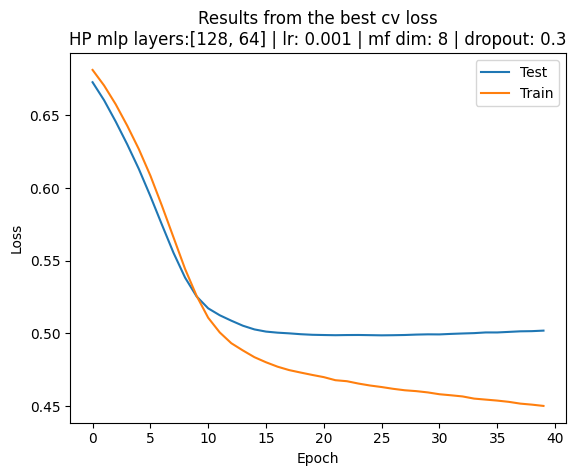

In [10]:
plt.plot(results["loss_ep"].loc[4]["test"], label = "Test")
plt.plot(results["loss_ep"].loc[4]["train"], label = "Train")
best = results.loc[4]
hp_string = f'mlp layers:{best["mlp_layer_sizes"]} | lr: {best["learning_rate"]} | mf dim: {best["mf_dim"]} | dropout: {best["dropout"]}'
plt.title("Results from the best cv loss\nHP " + hp_string)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

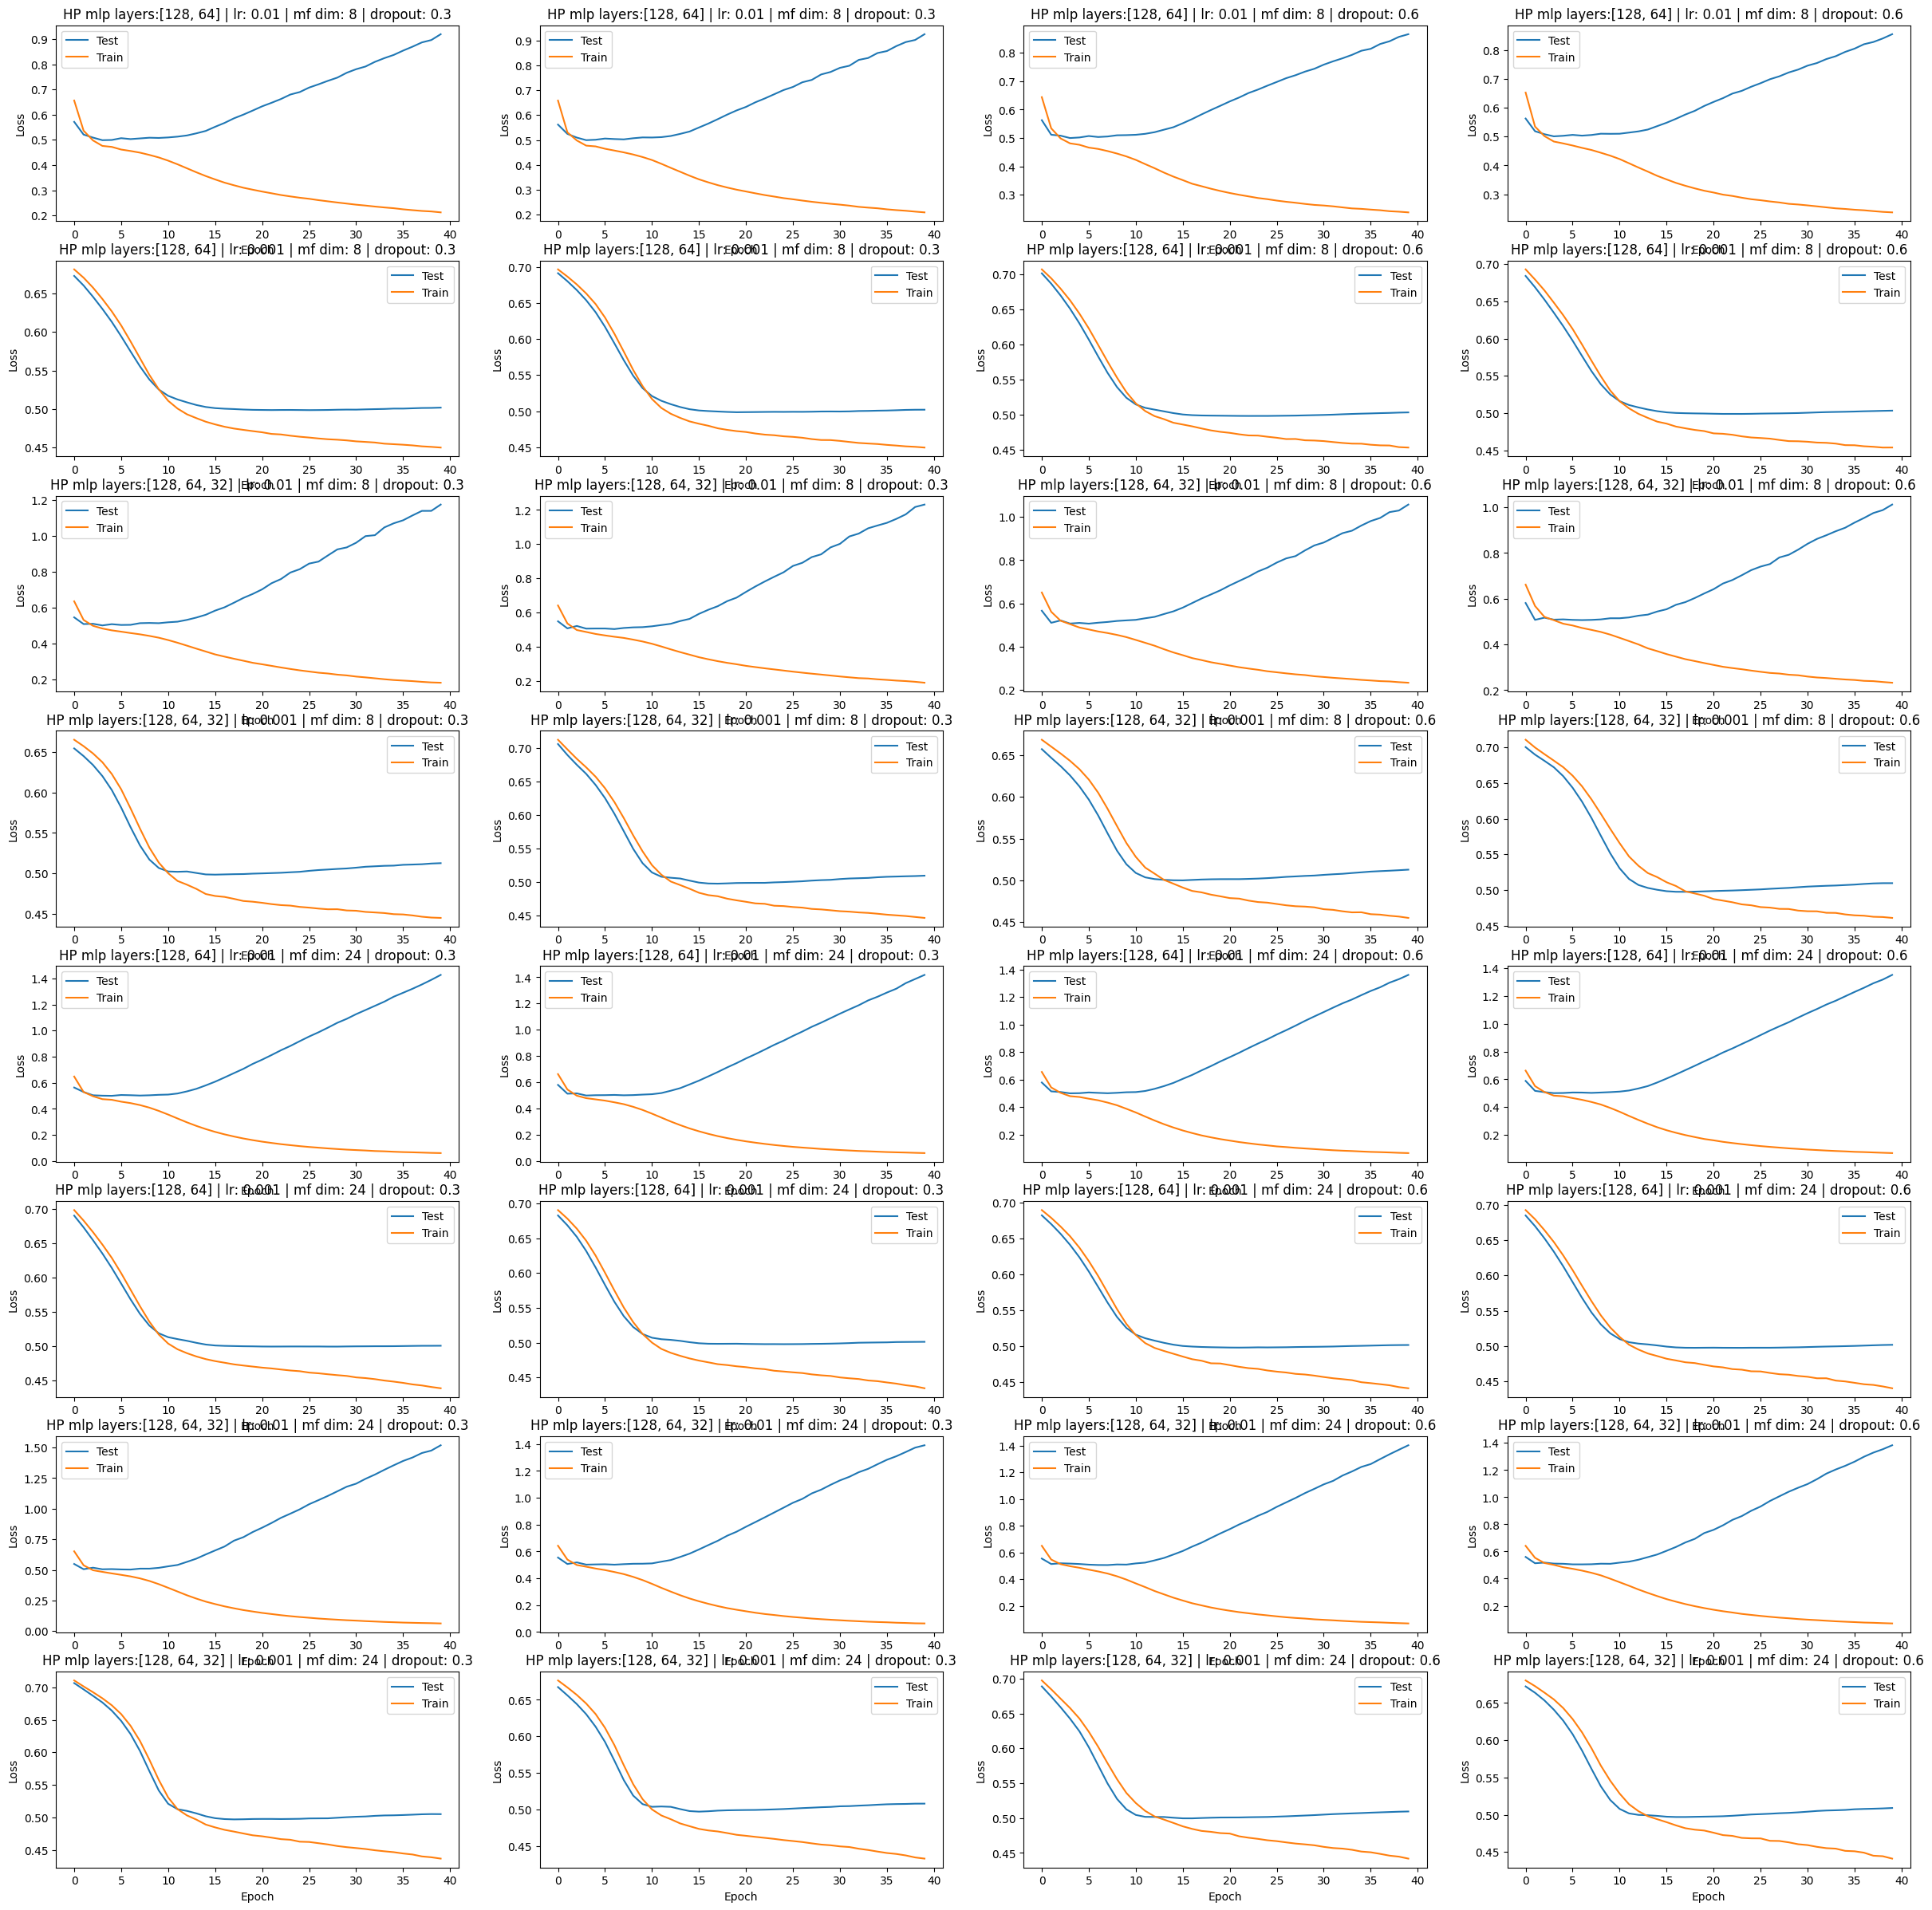

In [12]:
fig, axes = plt.subplots(nrows = 8, ncols = 4, figsize = (30, 30))
axes = axes.flatten()

for i, row in results.iterrows():
    axes[i].plot(row["loss_ep"]["test"], label = "Test")
    axes[i].plot(row["loss_ep"]["train"], label = "Train")
    hp_string = f'mlp layers:{row["mlp_layer_sizes"]} | lr: {row["learning_rate"]} | mf dim: {row["mf_dim"]} | dropout: {row["dropout"]}'
    axes[i].title.set_text("HP " + hp_string)
    axes[i].set(xlabel = "Epoch", ylabel = "Loss")
    axes[i].legend()

The optimal results were achieved with a 2-layer perceptron instead of a 3-layer one, but 3 layer perceptrons show good results aswell.

A high learning rate proved to be suboptimal, bigger learning rate caused overfitting to training data so validation loss got much higher.

The dimensionality of matrix factorization had a minor effect on the model's performance.

There were indications of overfitting; employing a learning rate scheduler could have been beneficial.

An extended grid search was not conducted due to computational dependencies. This single experiment took about 50 minutes.
